# Investigating Europian Football Dataset

## Table of Contents
<ul>
<li><a href="#intro">1- Introduction</a></li>
<li><a href="#wrangling">2- Data Wrangling</a></li>
<li><a href="#eda">3- Exploratory Data Analysis</a></li>
<li><a href="#conclusions">4- Conclusions</a></li>
</ul>


------------------------------------------------------------------

<a id='intro'></a>
## 1- Introduction

<font size="3">A popular Kaggle dataset is being used for this analysis, this dataset is called "European Soccer Database", it's a very extensive dataset that contains (according to Kaggle page)</font>

- 25,000 matches
- +10,000 players
- 11 European Countries with their lead championship
- Seasons 2008 to 2016
- Players and Teams' attributes* sourced from EA Sports' FIFA video game series, including the weekly updates
- Team line up with squad formation (X, Y coordinates)
- Betting odds from up to 10 providers
- Detailed match events (goal types, possession, corner, cross, fouls, cards etc...) for +10,000 matches



<font size="3">This data has been collected by the author from different sources as</font> 

- http://football-data.mx-api.enetscores.com/ : scores, lineup, team formation and events

- http://www.football-data.co.uk/ : betting odds. Click here to understand the column naming system for betting odds:

- http://sofifa.com/ : players and teams attributes from EA Sports FIFA games. FIFA series and all FIFA assets property of EA Sports.

<font size="3">The questions that I am trying to answer through this analysis are</font>

1. **What teams improved the most/worst over these years (2008-2016)?** <a href="#a1">Go to answer</a>
2. **What team attributes led to the most victories?** <a href="#a2">Go to answer</a>
3. **Which leagues, teams scored the most?** <a href="#a3a">Go to answer a</a> <a href="#a3b">Go to answer b</a>
4. **Does different leagues has special team charcteristics?** <a href="#a4">Go to answer</a>
5. **Who are the best players in Europe over these years (2008-2016)** <a href="#a5">Go to answer</a>
6. **Relationship between players height and weight vs player attributes?** <a href="#a6">Go to answer</a>


> **Importing the needed libraries**

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sqlite3
import seaborn as sns
%matplotlib inline

----------------------------

<a id='wrangling'></a>
## 2 Data Wrangling

### 2.1 General Properties

>  **Create a connection with the database, and then query the tables names**

In [3]:
conn = sqlite3.connect('database.sqlite')
tables = pd.read_sql(""" SELECT * FROM sqlite_master WHERE type='table'; """,conn)
tables

type               name           tbl_name  rootpage  \
0  table    sqlite_sequence    sqlite_sequence         4   
1  table  Player_Attributes  Player_Attributes        11   
2  table             Player             Player        14   
3  table              Match              Match        18   
4  table             League             League        24   
5  table            Country            Country        26   
6  table               Team               Team        29   
7  table    Team_Attributes    Team_Attributes         2   

                                                 sql  
0             CREATE TABLE sqlite_sequence(name,seq)  
1  CREATE TABLE "Player_Attributes" (\n\t`id`\tIN...  
2  CREATE TABLE `Player` (\n\t`id`\tINTEGER PRIMA...  
3  CREATE TABLE `Match` (\n\t`id`\tINTEGER PRIMAR...  
4  CREATE TABLE `League` (\n\t`id`\tINTEGER PRIMA...  
5  CREATE TABLE `Country` (\n\t`id`\tINTEGER PRIM...  
6  CREATE TABLE "Team" (\n\t`id`\tINTEGER PRIMARY...  
7  CREATE TABLE `Team_Attributes` (\n\t`id`\tINTE...

> **Query each table and load it in a pandas data frame**

In [4]:
countries = pd.read_sql("""SELECT *
                           FROM Country;""", conn)
leagues = pd.read_sql("""SELECT *
                         FROM League;""", conn)
matches = pd.read_sql("""SELECT *
                         FROM Match;""", conn)
teams = pd.read_sql("""SELECT *
                       FROM Team;""", conn)
team_attributes = pd.read_sql("""SELECT *
                                 FROM Team_Attributes;""", conn)
players = pd.read_sql("""SELECT *
                        FROM Player;""", conn)
players_attributes = pd.read_sql("""SELECT *
                                    FROM Player_Attributes;""", conn)

> **Checking each table for cleaning needs**

In [5]:
countries.head(2)

id     name
0     1  Belgium
1  1729  England

In [6]:
countries['id'].unique()

array([    1,  1729,  4769,  7809, 10257, 13274, 15722, 17642, 19694,
       21518, 24558])

In [7]:
leagues.head(2)

id  country_id                    name
0     1           1  Belgium Jupiler League
1  1729        1729  England Premier League

In [8]:
leagues['id'].unique()

array([    1,  1729,  4769,  7809, 10257, 13274, 15722, 17642, 19694,
       21518, 24558])

> **Cleaning Task #1**
Countries and Leagues tables can be combined in one table for simplicity, as we have only 11 leagues from 11 different countries in Europe, as one league per country, and we should then remove one of the two similar id columns (league_id and country_id) as they are exactly the same.

In [9]:
leagues = pd.merge(leagues, countries, on='id')

In [10]:
leagues = leagues.drop('country_id', axis=1)

In [11]:
leagues.rename(columns={'name_x':'league','name_y':'country'}, inplace=True)

In [12]:
leagues

id                    league      country
0       1    Belgium Jupiler League      Belgium
1    1729    England Premier League      England
2    4769            France Ligue 1       France
3    7809     Germany 1. Bundesliga      Germany
4   10257             Italy Serie A        Italy
5   13274    Netherlands Eredivisie  Netherlands
6   15722        Poland Ekstraklasa       Poland
7   17642  Portugal Liga ZON Sagres     Portugal
8   19694   Scotland Premier League     Scotland
9   21518           Spain LIGA BBVA        Spain
10  24558  Switzerland Super League  Switzerland

--------------------------------------------

In [13]:
matches.head()

id  country_id  league_id     season  stage                 date  \
0   1           1          1  2008/2009      1  2008-08-17 00:00:00   
1   2           1          1  2008/2009      1  2008-08-16 00:00:00   
2   3           1          1  2008/2009      1  2008-08-16 00:00:00   
3   4           1          1  2008/2009      1  2008-08-17 00:00:00   
4   5           1          1  2008/2009      1  2008-08-16 00:00:00   

   match_api_id  home_team_api_id  away_team_api_id  home_team_goal  ...  \
0        492473              9987              9993               1  ...   
1        492474             10000              9994               0  ...   
2        492475              9984              8635               0  ...   
3        492476              9991              9998               5  ...   
4        492477              7947              9985               1  ...   

    SJA   VCH   VCD   VCA   GBH   GBD   GBA   BSH   BSD   BSA  
0  4.00  1.65  3.40  4.50  1.78  3.25  4.00  1.73  3.40  4.20  
1  3.80  2.00  3.25  3.25  1.85  3.25  3.75  1.91  3.25  3.60  
2  2.50  2.35  3.25  2.65  2.50  3.20  2.50  2.30  3.20  2.75  
3  7.50  1.45  3.75  6.50  1.50  3.75  5.50  1.44  3.75  6.50  
4  1.73  4.50  3.40  1.65  4.50  3.50  1.65  4.75  3.30  1.67  

[5 rows x 115 columns]

In [14]:
matches.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25979 entries, 0 to 25978
Columns: 115 entries, id to BSA
dtypes: float64(96), int64(9), object(10)
memory usage: 22.8+ MB


In [15]:
for i, c in enumerate(matches.columns):
        print(i, c)

0 id
1 country_id
2 league_id
3 season
4 stage
5 date
6 match_api_id
7 home_team_api_id
8 away_team_api_id
9 home_team_goal
10 away_team_goal
11 home_player_X1
12 home_player_X2
13 home_player_X3
14 home_player_X4
15 home_player_X5
16 home_player_X6
17 home_player_X7
18 home_player_X8
19 home_player_X9
20 home_player_X10
21 home_player_X11
22 away_player_X1
23 away_player_X2
24 away_player_X3
25 away_player_X4
26 away_player_X5
27 away_player_X6
28 away_player_X7
29 away_player_X8
30 away_player_X9
31 away_player_X10
32 away_player_X11
33 home_player_Y1
34 home_player_Y2
35 home_player_Y3
36 home_player_Y4
37 home_player_Y5
38 home_player_Y6
39 home_player_Y7
40 home_player_Y8
41 home_player_Y9
42 home_player_Y10
43 home_player_Y11
44 away_player_Y1
45 away_player_Y2
46 away_player_Y3
47 away_player_Y4
48 away_player_Y5
49 away_player_Y6
50 away_player_Y7
51 away_player_Y8
52 away_player_Y9
53 away_player_Y10
54 away_player_Y11
55 home_player_1
56 home_player_2
57 home_player_3
58 home

In [16]:
matches['country_id'].unique()

array([    1,  1729,  4769,  7809, 10257, 13274, 15722, 17642, 19694,
       21518, 24558])

In [17]:
matches['league_id'].unique()

array([    1,  1729,  4769,  7809, 10257, 13274, 15722, 17642, 19694,
       21518, 24558])

In [18]:
matches['season'].unique()

array(['2008/2009', '2009/2010', '2010/2011', '2011/2012', '2012/2013',
       '2013/2014', '2014/2015', '2015/2016'], dtype=object)

In [19]:
for i, c in enumerate(matches.isnull().sum()):
    print(i,c)

0 0
1 0
2 0
3 0
4 0
5 0
6 0
7 0
8 0
9 0
10 0
11 1821
12 1821
13 1832
14 1832
15 1832
16 1832
17 1832
18 1832
19 1832
20 1832
21 1832
22 1832
23 1832
24 1832
25 1832
26 1832
27 1832
28 1832
29 1832
30 1833
31 1833
32 1839
33 1821
34 1821
35 1832
36 1832
37 1832
38 1832
39 1832
40 1832
41 1832
42 1832
43 1832
44 1832
45 1832
46 1832
47 1832
48 1832
49 1832
50 1832
51 1832
52 1833
53 1833
54 1839
55 1224
56 1315
57 1281
58 1323
59 1316
60 1325
61 1227
62 1309
63 1273
64 1436
65 1555
66 1234
67 1278
68 1293
69 1321
70 1335
71 1313
72 1235
73 1341
74 1328
75 1441
76 1554
77 11762
78 11762
79 11762
80 11762
81 11762
82 11762
83 11762
84 11762
85 3387
86 3387
87 3387
88 3404
89 3404
90 3404
91 3459
92 3459
93 3459
94 3423
95 3423
96 3423
97 14811
98 14811
99 14811
100 3408
101 3408
102 3408
103 8882
104 8882
105 8882
106 3411
107 3411
108 3411
109 11817
110 11817
111 11817
112 11818
113 11818
114 11818


In [20]:
matches['goal'].unique()

array([None,
       '<goal><value><comment>n</comment><stats><goals>1</goals><shoton>1</shoton></stats><event_incident_typefk>406</event_incident_typefk><elapsed>22</elapsed><player2>38807</player2><subtype>header</subtype><player1>37799</player1><sortorder>5</sortorder><team>10261</team><id>378998</id><n>295</n><type>goal</type><goal_type>n</goal_type></value><value><comment>n</comment><stats><goals>1</goals><shoton>1</shoton></stats><event_incident_typefk>393</event_incident_typefk><elapsed>24</elapsed><player2>24154</player2><subtype>shot</subtype><player1>24148</player1><sortorder>4</sortorder><team>10260</team><id>379019</id><n>298</n><type>goal</type><goal_type>n</goal_type></value></goal>',
       '<goal><value><comment>n</comment><stats><goals>1</goals><shoton>1</shoton></stats><event_incident_typefk>393</event_incident_typefk><elapsed>4</elapsed><player2>39297</player2><subtype>shot</subtype><player1>26181</player1><sortorder>2</sortorder><team>9825</team><id>375546</id><n>231

> **Wow, this Matches table is so rich, 25979 match records, with 115 attributes for each match record.**
>
> **The matches are being recorded from the 11 leagues over 8 seasons from 2008 to 2016.**
>
> **We only need 11 columns out of this table and other columns can be dropped for more efficiency for the following reasons**
>
> - There are 44 attributes that are out of the scope of this analysis, which are the X,Y locations of the players in each match
>
> - The match statistics as (shoton, shotoff, foulcommit, ... possession) are recorded in a very messy way that will need a lot of work to be correctly interpreted, and also our questions doesn't need this kind of data.
>
> - The last 30 columns are related to betting odds, which is out of the scope of this analysis
>
> - id, country_id and stage are redunant columns

> **Cleaning Task #2**
Drop the last 104 columns of the matches table as well as id, country_id and stage columns

In [21]:
matches = matches.drop(matches.columns[11:], axis=1)

In [22]:
matches = matches.drop(matches.columns[:2], axis=1)

In [23]:
matches = matches.drop(matches.columns[2], axis=1)

In [24]:
matches.head()

league_id     season                 date  match_api_id  home_team_api_id  \
0          1  2008/2009  2008-08-17 00:00:00        492473              9987   
1          1  2008/2009  2008-08-16 00:00:00        492474             10000   
2          1  2008/2009  2008-08-16 00:00:00        492475              9984   
3          1  2008/2009  2008-08-17 00:00:00        492476              9991   
4          1  2008/2009  2008-08-16 00:00:00        492477              7947   

   away_team_api_id  home_team_goal  away_team_goal  
0              9993               1               1  
1              9994               0               0  
2              8635               0               3  
3              9998               5               0  
4              9985               1               3

--------------------------------------------

In [25]:
teams.head(3)

id  team_api_id  team_fifa_api_id    team_long_name team_short_name
0   1         9987             673.0          KRC Genk             GEN
1   2         9993             675.0      Beerschot AC             BAC
2   3        10000           15005.0  SV Zulte-Waregem             ZUL

In [26]:
teams.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 299 entries, 0 to 298
Data columns (total 5 columns):
id                  299 non-null int64
team_api_id         299 non-null int64
team_fifa_api_id    288 non-null float64
team_long_name      299 non-null object
team_short_name     299 non-null object
dtypes: float64(1), int64(2), object(2)
memory usage: 11.8+ KB


> **Cleaning Task #3**
Too much id columns, let's just drop the team_fifa_api_id column

In [27]:
teams.drop(['id', 'team_fifa_api_id'], axis=1, inplace=True)

In [28]:
teams.head(2)

team_api_id team_long_name team_short_name
0         9987       KRC Genk             GEN
1         9993   Beerschot AC             BAC

--------------------------------------------------------------------------------------

In [29]:
team_attributes.head(3)

id  team_fifa_api_id  team_api_id                 date  buildUpPlaySpeed  \
0   1               434         9930  2010-02-22 00:00:00                60   
1   2               434         9930  2014-09-19 00:00:00                52   
2   3               434         9930  2015-09-10 00:00:00                47   

  buildUpPlaySpeedClass  buildUpPlayDribbling buildUpPlayDribblingClass  \
0              Balanced                   NaN                    Little   
1              Balanced                  48.0                    Normal   
2              Balanced                  41.0                    Normal   

   buildUpPlayPassing buildUpPlayPassingClass  ... chanceCreationShooting  \
0                  50                   Mixed  ...                     55   
1                  56                   Mixed  ...                     64   
2                  54                   Mixed  ...                     64   

   chanceCreationShootingClass chanceCreationPositioningClass  \
0                       Normal                      Organised   
1                       Normal                      Organised   
2                       Normal                      Organised   

   defencePressure defencePressureClass  defenceAggression  \
0               50               Medium                 55   
1               47               Medium                 44   
2               47               Medium                 44   

  defenceAggressionClass defenceTeamWidth  defenceTeamWidthClass  \
0                  Press               45                 Normal   
1                  Press               54                 Normal   
2                  Press               54                 Normal   

  defenceDefenderLineClass  
0                    Cover  
1                    Cover  
2                    Cover  

[3 rows x 25 columns]

In [30]:
team_attributes.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1458 entries, 0 to 1457
Data columns (total 25 columns):
id                                1458 non-null int64
team_fifa_api_id                  1458 non-null int64
team_api_id                       1458 non-null int64
date                              1458 non-null object
buildUpPlaySpeed                  1458 non-null int64
buildUpPlaySpeedClass             1458 non-null object
buildUpPlayDribbling              489 non-null float64
buildUpPlayDribblingClass         1458 non-null object
buildUpPlayPassing                1458 non-null int64
buildUpPlayPassingClass           1458 non-null object
buildUpPlayPositioningClass       1458 non-null object
chanceCreationPassing             1458 non-null int64
chanceCreationPassingClass        1458 non-null object
chanceCreationCrossing            1458 non-null int64
chanceCreationCrossingClass       1458 non-null object
chanceCreationShooting            1458 non-null int64
chanceCreationShootin

In [31]:
team_attributes.date.unique()

array(['2010-02-22 00:00:00', '2014-09-19 00:00:00',
       '2015-09-10 00:00:00', '2011-02-22 00:00:00',
       '2012-02-22 00:00:00', '2013-09-20 00:00:00'], dtype=object)

> **This tables has team attributes records for the 299 teams in 6 different seasons**
>
> **The date attribute need to be similar to the season attribute in the match table for further merge options**
>
> **The buildUpPlayDribbling is lacking many values, and it is not very important to our analysis**


> **Cleaning Task #4**
Reflect date to season, and drop id, team_fifa_api_id, buildUpPlayDribbling columns in team attributes table

In [32]:
team_attributes.drop(['id','team_fifa_api_id', 'buildUpPlayDribbling'], axis=1, inplace=True)

In [33]:
def convert_date_to_season (row):
    if row['date'] == '2010-02-22 00:00:00':
        return '2009/2010'
    if row['date'] == '2014-09-19 00:00:00':
        return '2014/2015'
    if row['date'] == '2015-09-10 00:00:00':
        return '2015/2016'
    if row['date'] == '2011-02-22 00:00:00':
        return '2010/2011'
    if row['date'] == '2012-02-22 00:00:00':
        return '2011/2012'
    if row['date'] == '2013-09-20 00:00:00':
        return '2013/2014'

In [34]:
team_attributes['date'] = team_attributes.apply(convert_date_to_season, axis=1)

In [35]:
team_attributes.head()

team_api_id       date  buildUpPlaySpeed buildUpPlaySpeedClass  \
0         9930  2009/2010                60              Balanced   
1         9930  2014/2015                52              Balanced   
2         9930  2015/2016                47              Balanced   
3         8485  2009/2010                70                  Fast   
4         8485  2010/2011                47              Balanced   

  buildUpPlayDribblingClass  buildUpPlayPassing buildUpPlayPassingClass  \
0                    Little                  50                   Mixed   
1                    Normal                  56                   Mixed   
2                    Normal                  54                   Mixed   
3                    Little                  70                    Long   
4                    Little                  52                   Mixed   

  buildUpPlayPositioningClass  chanceCreationPassing  \
0                   Organised                     60   
1                   Organised                     54   
2                   Organised                     54   
3                   Organised                     70   
4                   Organised                     53   

  chanceCreationPassingClass  ...  chanceCreationShooting  \
0                     Normal  ...                      55   
1                     Normal  ...                      64   
2                     Normal  ...                      64   
3                      Risky  ...                      70   
4                     Normal  ...                      52   

  chanceCreationShootingClass  chanceCreationPositioningClass defencePressure  \
0                      Normal                       Organised              50   
1                      Normal                       Organised              47   
2                      Normal                       Organised              47   
3                        Lots                       Organised              60   
4                      Normal                       Organised              47   

  defencePressureClass  defenceAggression defenceAggressionClass  \
0               Medium                 55                  Press   
1               Medium                 44                  Press   
2               Medium                 44                  Press   
3               Medium                 70                 Double   
4               Medium                 47                  Press   

   defenceTeamWidth defenceTeamWidthClass  defenceDefenderLineClass  
0                45                Normal                     Cover  
1                54                Normal                     Cover  
2                54                Normal                     Cover  
3                70                  Wide                     Cover  
4                52                Normal                     Cover  

[5 rows x 22 columns]

-------------------------------------------

In [36]:
players.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11060 entries, 0 to 11059
Data columns (total 7 columns):
id                    11060 non-null int64
player_api_id         11060 non-null int64
player_name           11060 non-null object
player_fifa_api_id    11060 non-null int64
birthday              11060 non-null object
height                11060 non-null float64
weight                11060 non-null int64
dtypes: float64(1), int64(4), object(2)
memory usage: 605.0+ KB


> **Cleaning Task #5**
Drop id, player_fifa_api_id

In [37]:
players.drop(['id', 'player_fifa_api_id'], axis=1, inplace=True)

In [38]:
players.head(2)

player_api_id         player_name             birthday  height  weight
0         505942  Aaron Appindangoye  1992-02-29 00:00:00  182.88     187
1         155782     Aaron Cresswell  1989-12-15 00:00:00  170.18     146

--------------------------------------------

In [39]:
players_attributes.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 183978 entries, 0 to 183977
Data columns (total 42 columns):
id                     183978 non-null int64
player_fifa_api_id     183978 non-null int64
player_api_id          183978 non-null int64
date                   183978 non-null object
overall_rating         183142 non-null float64
potential              183142 non-null float64
preferred_foot         183142 non-null object
attacking_work_rate    180748 non-null object
defensive_work_rate    183142 non-null object
crossing               183142 non-null float64
finishing              183142 non-null float64
heading_accuracy       183142 non-null float64
short_passing          183142 non-null float64
volleys                181265 non-null float64
dribbling              183142 non-null float64
curve                  181265 non-null float64
free_kick_accuracy     183142 non-null float64
long_passing           183142 non-null float64
ball_control           183142 non-null float64
accele

In [40]:
players_attributes['date'].nunique()

197

> **This tables has player attributes records for the 11060 players in 197 different timing (probably on weekly basis)**


> **Cleaning Task #6**
Drop id, player_fifa_api_id in player attributes

In [41]:
players_attributes.drop(['id', 'player_fifa_api_id'], axis=1, inplace=True)

In [42]:
players_attributes.head(2)

player_api_id                 date  overall_rating  potential  \
0         505942  2016-02-18 00:00:00            67.0       71.0   
1         505942  2015-11-19 00:00:00            67.0       71.0   

  preferred_foot attacking_work_rate defensive_work_rate  crossing  finishing  \
0          right              medium              medium      49.0       44.0   
1          right              medium              medium      49.0       44.0   

   heading_accuracy  ...  vision  penalties  marking  standing_tackle  \
0              71.0  ...    54.0       48.0     65.0             69.0   
1              71.0  ...    54.0       48.0     65.0             69.0   

   sliding_tackle  gk_diving  gk_handling  gk_kicking  gk_positioning  \
0            69.0        6.0         11.0        10.0             8.0   
1            69.0        6.0         11.0        10.0             8.0   

   gk_reflexes  
0          8.0  
1          8.0  

[2 rows x 40 columns]

<a id='eda'></a>
## 3 Exploratory Data Analysis


### 3.1 What teams improved the most/worst over these years (2008-2016)?

> **The important question here is how to measure the success of a team, I think the best criterion will be the win ratio i.e the number of wins divided by the total numbers of matches played per season**
>
> **And to measure the improvement, let's calculate the win ratio for each team in the first and the last seasons of our data interval time and then subtract them i.e last minus first, to have an indicator of how much a team improved or even how much it deteriorated**

In [43]:
#A function that generate a new column that represents the result in terms of win, tie or loss 
#   from the perspective of the home team

def home_result_func(row):
    if row['home_team_goal'] > row['away_team_goal']:
        val = 'win'
    elif row['home_team_goal'] == row['away_team_goal']:
        val = 'tie'
    else:
        val = 'loss'
    return val

In [44]:
matches['home_result'] = matches.apply(home_result_func, axis=1)

In [45]:
matches.head()

league_id     season                 date  match_api_id  home_team_api_id  \
0          1  2008/2009  2008-08-17 00:00:00        492473              9987   
1          1  2008/2009  2008-08-16 00:00:00        492474             10000   
2          1  2008/2009  2008-08-16 00:00:00        492475              9984   
3          1  2008/2009  2008-08-17 00:00:00        492476              9991   
4          1  2008/2009  2008-08-16 00:00:00        492477              7947   

   away_team_api_id  home_team_goal  away_team_goal home_result  
0              9993               1               1         tie  
1              9994               0               0         tie  
2              8635               0               3        loss  
3              9998               5               0         win  
4              9985               1               3        loss

In [46]:
# to compute the win ratio, we need to know how many matches a team played per season
no_of_matches_played_as_home = matches.groupby(['season','home_team_api_id'])['match_api_id'].count()

In [47]:
no_of_matches_played_as_home

season     home_team_api_id
2008/2009  1601                15
           1957                15
           2182                15
           2183                15
           2186                15
                               ..
2015/2016  158085              17
           177361              15
           188163              17
           208931              19
           274581              15
Name: match_api_id, Length: 1481, dtype: int64

In [48]:
no_of_matches_played_as_away = matches.groupby(['season','away_team_api_id'])['match_api_id'].count()

In [49]:
no_of_matches_played_as_away

season     away_team_api_id
2008/2009  1601                15
           1957                15
           2182                15
           2183                15
           2186                15
                               ..
2015/2016  158085              17
           177361              15
           188163              17
           208931              19
           274581              15
Name: match_api_id, Length: 1481, dtype: int64

In [50]:
# to compute the win ratio, we need to know how many matches a team won per season, either as home or away
no_of_win_as_home = matches.query(" home_result=='win' ").groupby(['season','home_team_api_id'])['match_api_id'].count()

In [51]:
no_of_win_as_home

season     home_team_api_id
2008/2009  1601                6
           1957                9
           2182                7
           2183                7
           2186                6
                              ..
2015/2016  158085              8
           177361              5
           188163              3
           208931              6
           274581              3
Name: match_api_id, Length: 1480, dtype: int64

In [52]:
no_of_win_as_away = matches.query(" home_result=='loss' ").groupby(['season','away_team_api_id'])['match_api_id'].count()

In [53]:
no_of_win_as_away

season     away_team_api_id
2008/2009  1601                3
           2182                9
           2183                8
           2186                1
           4049                1
                              ..
2015/2016  158085              5
           177361              3
           188163              5
           208931              3
           274581              4
Name: match_api_id, Length: 1463, dtype: int64

In [54]:
no_of_loss_as_home = matches.query(" home_result=='loss' ").groupby(['season','home_team_api_id'])['match_api_id'].count()

In [55]:
no_of_loss_as_away = matches.query(" home_result=='win' ").groupby(['season','away_team_api_id'])['match_api_id'].count()

> **A problem occurs here as some teams may never won a match as home/away or even never lost a match, this causes that these teams won't appear in the previous series (you can notice the different length of these series), so to fix that we need to add the missing teams with a corresponding value of zero**

In [56]:
# A good reference series will be the no_of_matches_played_as_home, as it must include all the participating
#   teams in this league at this season

# So a list of all the team ids will be created, and then it will be combined with the incomplete series
#   and the missing teams will have a value of zero
teams_id_list = no_of_matches_played_as_home.index.to_list()
support_series = pd.Series(0, index = teams_id_list)

In [57]:
support_series

(2008/2009, 1601)      0
(2008/2009, 1957)      0
(2008/2009, 2182)      0
(2008/2009, 2183)      0
(2008/2009, 2186)      0
                      ..
(2015/2016, 158085)    0
(2015/2016, 177361)    0
(2015/2016, 188163)    0
(2015/2016, 208931)    0
(2015/2016, 274581)    0
Length: 1481, dtype: int64

In [58]:
no_of_win_as_home = no_of_win_as_home.combine(support_series, max,fill_value=0)
no_of_win_as_away = no_of_win_as_away.combine(support_series, max,fill_value=0)
no_of_loss_as_home = no_of_loss_as_home.combine(support_series, max,fill_value=0)
no_of_loss_as_away = no_of_loss_as_away.combine(support_series, max,fill_value=0)

In [59]:
results_df = pd.DataFrame({'matches_as_home':no_of_matches_played_as_home,'matches_as_away':no_of_matches_played_as_away,'won_as_home':no_of_win_as_home, 'won_as_away':no_of_win_as_away,'lost_as_home':no_of_loss_as_home,'lost_as_away':no_of_loss_as_away})

In [60]:
results_df

matches_as_home  matches_as_away  won_as_home  \
season    home_team_api_id                                                  
2008/2009 1601                           15               15            6   
          1957                           15               15            9   
          2182                           15               15            7   
          2183                           15               15            7   
          2186                           15               15            6   
...                                     ...              ...          ...   
2015/2016 158085                         17               17            8   
          177361                         15               15            5   
          188163                         17               17            3   
          208931                         19               19            6   
          274581                         15               15            3   

                            won_as_away  lost_as_home  lost_as_away  
season    home_team_api_id                                           
2008/2009 1601                        3             6             8  
          1957                        0             4            10  
          2182                        9             1             2  
          2183                        8             2             4  
          2186                        1             3            11  
...                                 ...           ...           ...  
2015/2016 158085                      5             3             3  
          177361                      3             6             7  
          188163                      5            10            10  
          208931                      3             8            10  
          274581                      4             7             7  

[1481 rows x 6 columns]

In [61]:
results_df['total_played'] = results_df['matches_as_home'] + results_df['matches_as_away']
results_df['total_win'] = results_df['won_as_home'] + results_df['won_as_away']
results_df['total_lose'] = results_df['lost_as_home'] + results_df['lost_as_away']
results_df['total_draw'] = results_df['total_played'] - results_df['total_win'] - results_df['total_lose']

In [62]:
results_df.head()

matches_as_home  matches_as_away  won_as_home  \
season    home_team_api_id                                                  
2008/2009 1601                           15               15            6   
          1957                           15               15            9   
          2182                           15               15            7   
          2183                           15               15            7   
          2186                           15               15            6   

                            won_as_away  lost_as_home  lost_as_away  \
season    home_team_api_id                                            
2008/2009 1601                        3             6             8   
          1957                        0             4            10   
          2182                        9             1             2   
          2183                        8             2             4   
          2186                        1             3            11   

                            total_played  total_win  total_lose  total_draw  
season    home_team_api_id                                                   
2008/2009 1601                        30          9          14           7  
          1957                        30          9          14           7  
          2182                        30         16           3          11  
          2183                        30         15           6           9  
          2186                        30          7          14           9

In [63]:
results_df.index.names = ['season','team_api_id']

In [64]:
results_df['win_ratio_per_season'] = results_df['total_win'] / results_df['total_played']

In [65]:
results_df.head()

matches_as_home  matches_as_away  won_as_home  \
season    team_api_id                                                  
2008/2009 1601                      15               15            6   
          1957                      15               15            9   
          2182                      15               15            7   
          2183                      15               15            7   
          2186                      15               15            6   

                       won_as_away  lost_as_home  lost_as_away  total_played  \
season    team_api_id                                                          
2008/2009 1601                   3             6             8            30   
          1957                   0             4            10            30   
          2182                   9             1             2            30   
          2183                   8             2             4            30   
          2186                   1             3            11            30   

                       total_win  total_lose  total_draw  win_ratio_per_season  
season    team_api_id                                                           
2008/2009 1601                 9          14           7              0.300000  
          1957                 9          14           7              0.300000  
          2182                16           3          11              0.533333  
          2183                15           6           9              0.500000  
          2186                 7          14           9              0.233333

In [66]:
improvment_factor = results_df.groupby(['team_api_id'])['win_ratio_per_season'].last() - results_df.groupby(['team_api_id'])['win_ratio_per_season'].first()

In [67]:
improvment_factor

team_api_id
1601      0.066667
1773      0.000000
1957      0.033333
2033      0.033333
2182     -0.100000
            ...   
158085    0.115686
177361    0.000000
188163    0.000000
208931    0.000000
274581    0.000000
Name: win_ratio_per_season, Length: 299, dtype: float64

> **Now after having the improvement factor, we need to combine that with teams names for visulaizing charts**

In [68]:
teams_vs_improvement = pd.merge(left=teams, right=improvment_factor, on='team_api_id')

In [69]:
teams_vs_improvement.head(3)

team_api_id    team_long_name team_short_name  win_ratio_per_season
0         9987          KRC Genk             GEN              0.025490
1         9993      Beerschot AC             BAC             -0.123529
2        10000  SV Zulte-Waregem             ZUL             -0.070588

In [70]:
teams_vs_improvement.rename(columns={'win_ratio_per_season':'improvement_factor'}, inplace=True)

In [71]:
teams_vs_improvement.head(2)

team_api_id team_long_name team_short_name  improvement_factor
0         9987       KRC Genk             GEN            0.025490
1         9993   Beerschot AC             BAC           -0.123529

In [72]:
teams_vs_improvement.sort_values(by='improvement_factor',ascending=False, inplace=True)

In [73]:
teams_vs_improvement['improvement_factor'] = teams_vs_improvement['improvement_factor'] * 100

<a id='a1'></a>
#### Answer of question 1

In [75]:
teams_vs_improvement[-10:]

team_api_id          team_long_name team_short_name  improvement_factor
151         9876           Hellas Verona             VER          -28.947368
109        10269           VfB Stuttgart             STU          -29.411765
192         8569           GKS Bełchatów             BEL          -30.000000
9           9985       Standard de Liège             STL          -30.588235
61          9827   Girondins de Bordeaux             BOR          -31.578947
74          8592  Olympique de Marseille             MAR          -31.578947
43          8455                 Chelsea             CHE          -34.210526
181        10265            Wisła Kraków             WIS          -36.666667
33         10252             Aston Villa             AVL          -36.842105
293        10243               FC Zürich             ZUR          -47.222222

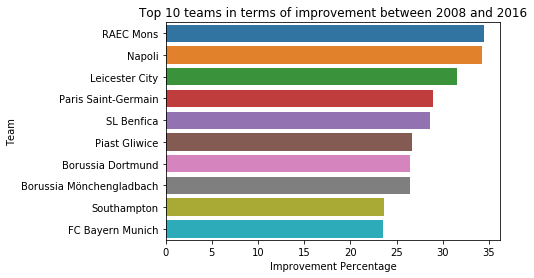

In [104]:
chart = sns.barplot(x='improvement_factor', y='team_long_name', data=teams_vs_improvement[:10])
chart.set(title='Top 10 teams in terms of improvement between 2008 and 2016',xlabel="Improvement Percentage", ylabel="Team");

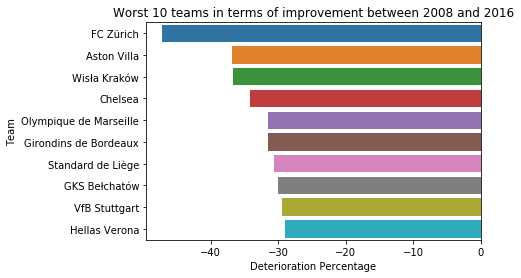

In [103]:
chart = sns.barplot(x='improvement_factor', y='team_long_name', data=teams_vs_improvement[-10:].sort_values(by='improvement_factor'))
chart.set(title='Worst 10 teams in terms of improvement between 2008 and 2016',xlabel="Deterioration Percentage", ylabel="Team");

--------------------------------------------------------------------------------------


### 3.2 What team attributes led to the most victories?

In [106]:
team_attributes.head(2)

team_api_id       date  buildUpPlaySpeed buildUpPlaySpeedClass  \
0         9930  2009/2010                60              Balanced   
1         9930  2014/2015                52              Balanced   

  buildUpPlayDribblingClass  buildUpPlayPassing buildUpPlayPassingClass  \
0                    Little                  50                   Mixed   
1                    Normal                  56                   Mixed   

  buildUpPlayPositioningClass  chanceCreationPassing  \
0                   Organised                     60   
1                   Organised                     54   

  chanceCreationPassingClass  ...  chanceCreationShooting  \
0                     Normal  ...                      55   
1                     Normal  ...                      64   

  chanceCreationShootingClass  chanceCreationPositioningClass defencePressure  \
0                      Normal                       Organised              50   
1                      Normal                       Organised              47   

  defencePressureClass  defenceAggression defenceAggressionClass  \
0               Medium                 55                  Press   
1               Medium                 44                  Press   

   defenceTeamWidth defenceTeamWidthClass  defenceDefenderLineClass  
0                45                Normal                     Cover  
1                54                Normal                     Cover  

[2 rows x 22 columns]

In [111]:
results_df.head(2)

matches_as_home  matches_as_away  won_as_home  \
season    team_api_id                                                  
2008/2009 1601                      15               15            6   
          1957                      15               15            9   

                       won_as_away  lost_as_home  lost_as_away  total_played  \
season    team_api_id                                                          
2008/2009 1601                   3             6             8            30   
          1957                   0             4            10            30   

                       total_win  total_lose  total_draw  win_ratio_per_season  
season    team_api_id                                                           
2008/2009 1601                 9          14           7                   0.3  
          1957                 9          14           7                   0.3

> **Now, we need to merge the team attributes table with the (generated from previous question table) results table, making use of the cleaning task that converted the date column in team attributes table to reflect to season column in matches table**

In [112]:
team_atts_vs_results = pd.merge(left=team_attributes, right=results_df, how='inner', left_on=['team_api_id', 'date'], right_on=['team_api_id', 'season'])

In [113]:
team_atts_vs_results.head(2)

team_api_id       date  buildUpPlaySpeed buildUpPlaySpeedClass  \
0         9930  2009/2010                60              Balanced   
1         9930  2014/2015                52              Balanced   

  buildUpPlayDribblingClass  buildUpPlayPassing buildUpPlayPassingClass  \
0                    Little                  50                   Mixed   
1                    Normal                  56                   Mixed   

  buildUpPlayPositioningClass  chanceCreationPassing  \
0                   Organised                     60   
1                   Organised                     54   

  chanceCreationPassingClass  ...  matches_as_away won_as_home  won_as_away  \
0                     Normal  ...               18           4            2   
1                     Normal  ...               18           5            1   

  lost_as_home lost_as_away  total_played total_win  total_lose total_draw  \
0           12           13            36         6          25          5   
1           10            8            36         6          18         12   

   win_ratio_per_season  
0              0.166667  
1              0.166667  

[2 rows x 33 columns]

> **Now we have a table that has one record for each team per season that has the team attributes during this season as well as the team results per this season**

In [108]:
team_atts_vs_results.columns

Index(['team_api_id', 'date', 'buildUpPlaySpeed', 'buildUpPlaySpeedClass',
       'buildUpPlayDribblingClass', 'buildUpPlayPassing',
       'buildUpPlayPassingClass', 'buildUpPlayPositioningClass',
       'chanceCreationPassing', 'chanceCreationPassingClass',
       'chanceCreationCrossing', 'chanceCreationCrossingClass',
       'chanceCreationShooting', 'chanceCreationShootingClass',
       'chanceCreationPositioningClass', 'defencePressure',
       'defencePressureClass', 'defenceAggression', 'defenceAggressionClass',
       'defenceTeamWidth', 'defenceTeamWidthClass', 'defenceDefenderLineClass',
       'matches_as_home', 'matches_as_away', 'won_as_home', 'won_as_away',
       'lost_as_home', 'lost_as_away', 'total_played', 'total_win',
       'total_lose', 'total_draw', 'win_ratio_per_season'],
      dtype='object')

<a id='a2'></a>
#### Answer of question 2

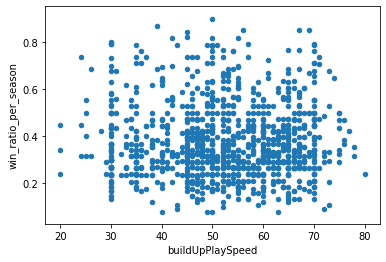

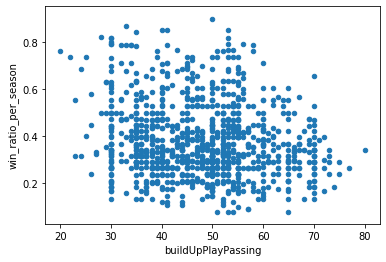

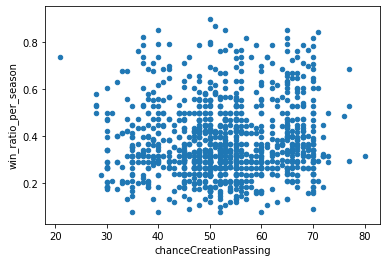

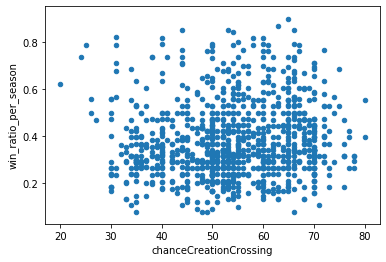

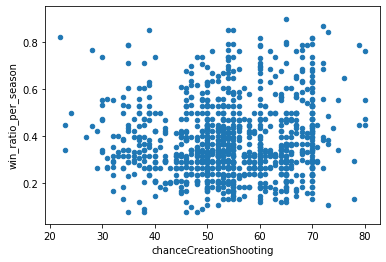

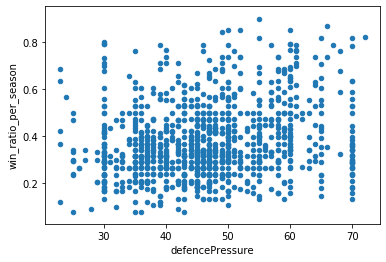

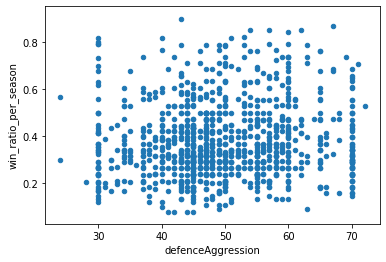

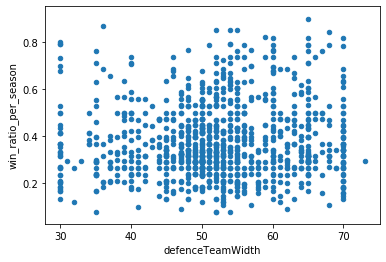

In [109]:
team_atts_vs_results.plot.scatter(x='buildUpPlaySpeed', y='win_ratio_per_season')
team_atts_vs_results.plot.scatter(x='buildUpPlayPassing', y='win_ratio_per_season')
team_atts_vs_results.plot.scatter(x='chanceCreationPassing', y='win_ratio_per_season')
team_atts_vs_results.plot.scatter(x='chanceCreationCrossing', y='win_ratio_per_season')
team_atts_vs_results.plot.scatter(x='chanceCreationShooting', y='win_ratio_per_season')
team_atts_vs_results.plot.scatter(x='defencePressure', y='win_ratio_per_season')
team_atts_vs_results.plot.scatter(x='defenceAggression', y='win_ratio_per_season')
team_atts_vs_results.plot.scatter(x='defenceTeamWidth', y='win_ratio_per_season');

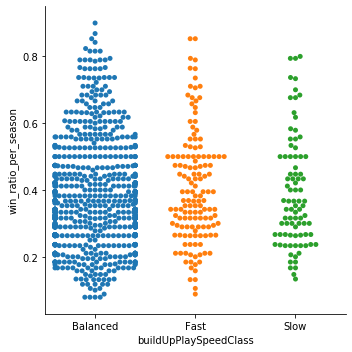

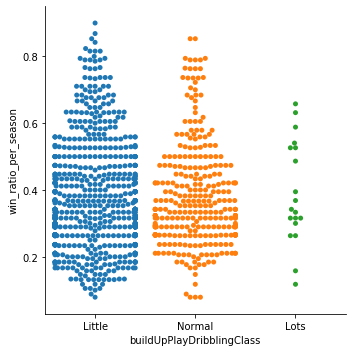

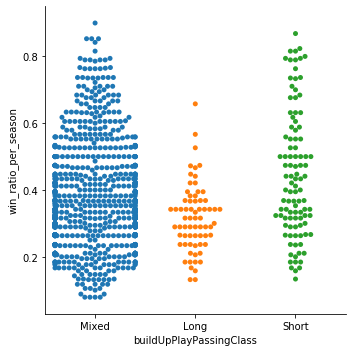

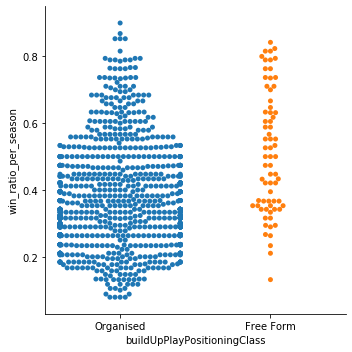

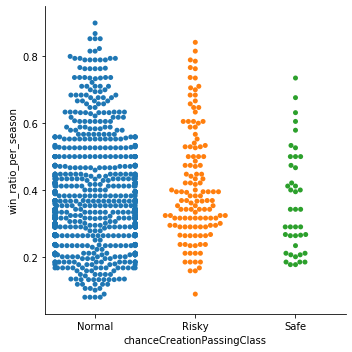

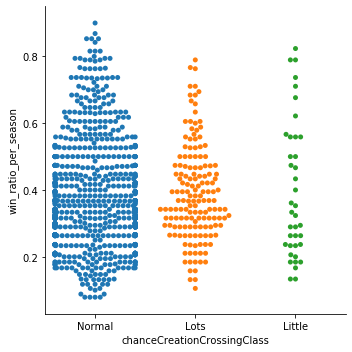

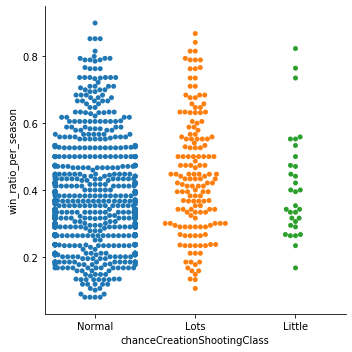

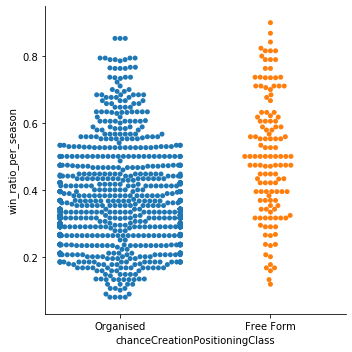

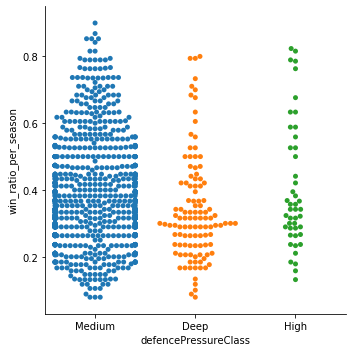

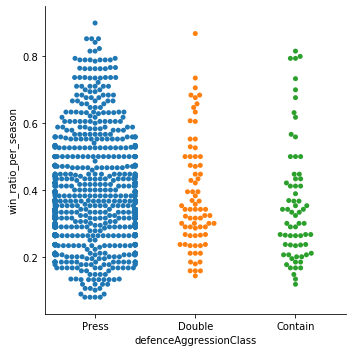

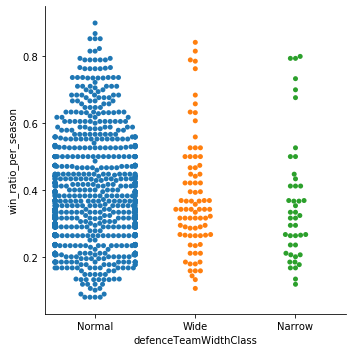

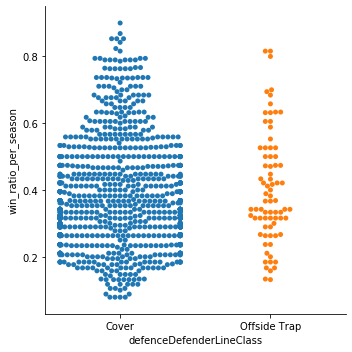

In [115]:
sns.catplot(x="buildUpPlaySpeedClass", y="win_ratio_per_season", kind='swarm', data=team_atts_vs_results)
sns.catplot(x="buildUpPlayDribblingClass", y="win_ratio_per_season", kind='swarm', data=team_atts_vs_results)
sns.catplot(x="buildUpPlayPassingClass", y="win_ratio_per_season", kind='swarm', data=team_atts_vs_results)
sns.catplot(x="buildUpPlayPositioningClass", y="win_ratio_per_season", kind='swarm', data=team_atts_vs_results)
sns.catplot(x="chanceCreationPassingClass", y="win_ratio_per_season", kind='swarm', data=team_atts_vs_results)
sns.catplot(x="chanceCreationCrossingClass", y="win_ratio_per_season", kind='swarm', data=team_atts_vs_results)
sns.catplot(x="chanceCreationShootingClass", y="win_ratio_per_season", kind='swarm', data=team_atts_vs_results)
sns.catplot(x="chanceCreationPositioningClass", y="win_ratio_per_season", kind='swarm', data=team_atts_vs_results)
sns.catplot(x="defencePressureClass", y="win_ratio_per_season", kind='swarm', data=team_atts_vs_results)
sns.catplot(x="defenceAggressionClass", y="win_ratio_per_season", kind='swarm', data=team_atts_vs_results)
sns.catplot(x="defenceTeamWidthClass", y="win_ratio_per_season", kind='swarm', data=team_atts_vs_results)
sns.catplot(x="defenceDefenderLineClass", y="win_ratio_per_season", kind='swarm', data=team_atts_vs_results);

--------------------------------------------------


### 3.3 Which leagues/teams scored the most?

In [77]:
matches.head()

league_id     season                 date  match_api_id  home_team_api_id  \
0          1  2008/2009  2008-08-17 00:00:00        492473              9987   
1          1  2008/2009  2008-08-16 00:00:00        492474             10000   
2          1  2008/2009  2008-08-16 00:00:00        492475              9984   
3          1  2008/2009  2008-08-17 00:00:00        492476              9991   
4          1  2008/2009  2008-08-16 00:00:00        492477              7947   

   away_team_api_id  home_team_goal  away_team_goal home_result  
0              9993               1               1         tie  
1              9994               0               0         tie  
2              8635               0               3        loss  
3              9998               5               0         win  
4              9985               1               3        loss

In [78]:
# We need to calculate how many matches played for each league in the data interval time
#    date here is an arbitary value only
total_matches_played_per_league = matches.groupby(['league_id'])['date'].count()

In [79]:
total_matches_played_per_league

league_id
1        1728
1729     3040
4769     3040
7809     2448
10257    3017
13274    2448
15722    1920
17642    2052
19694    1824
21518    3040
24558    1422
Name: date, dtype: int64

In [80]:
goals_as_home = matches.groupby(['league_id'])['home_team_goal'].sum()

In [81]:
goals_as_home

league_id
1        2781
1729     4715
4769     4265
7809     3982
10257    4528
13274    4357
15722    2678
17642    2890
19694    2607
21518    4959
24558    2365
Name: home_team_goal, dtype: int64

In [82]:
goals_as_away = matches.groupby(['league_id'])['away_team_goal'].sum()

In [83]:
total_goals = goals_as_home + goals_as_away

In [84]:
leagues_goals_df = pd.DataFrame({'no_of_matches_played':total_matches_played_per_league,'no_of_goals_as_home':goals_as_home,'no_of_goals_as_away':goals_as_away,'total_goals':total_goals})

In [85]:
# Table that shows goals statistics for each league over the data interval time
leagues_goals_df

no_of_matches_played  no_of_goals_as_home  no_of_goals_as_away  \
league_id                                                                   
1                          1728                 2781                 2060   
1729                       3040                 4715                 3525   
4769                       3040                 4265                 3162   
7809                       2448                 3982                 3121   
10257                      3017                 4528                 3367   
13274                      2448                 4357                 3185   
15722                      1920                 2678                 1978   
17642                      2052                 2890                 2311   
19694                      1824                 2607                 2197   
21518                      3040                 4959                 3453   
24558                      1422                 2365                 1801   

           total_goals  
league_id               
1                 4841  
1729              8240  
4769              7427  
7809              7103  
10257             7895  
13274             7542  
15722             4656  
17642             5201  
19694             4804  
21518             8412  
24558             4166

In [86]:
leagues_goals_df['goals_per_match'] = leagues_goals_df['total_goals'] / leagues_goals_df['no_of_matches_played']

In [87]:
leagues_goals_df = leagues.merge(leagues_goals_df, how='inner', left_on='id', right_on='league_id')

In [88]:
leagues_goals_df.drop(['country'], axis=1, inplace=True)

In [89]:
leagues_goals_df.head(2)

id                  league  no_of_matches_played  no_of_goals_as_home  \
0     1  Belgium Jupiler League                  1728                 2781   
1  1729  England Premier League                  3040                 4715   

   no_of_goals_as_away  total_goals  goals_per_match  
0                 2060         4841         2.801505  
1                 3525         8240         2.710526

<a id='a3a'></a>
#### Answer of question 3a

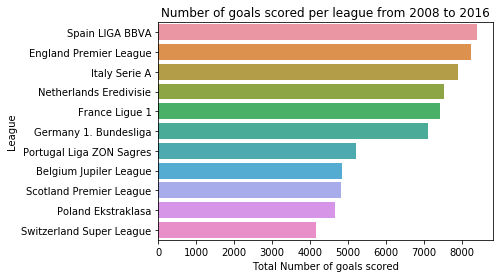

In [90]:
leagues_goals_df.sort_values(by='total_goals', ascending=False, inplace=True)
chart = sns.barplot(x='total_goals', y='league', data=leagues_goals_df)
chart.set(title='Number of goals scored per league from 2008 to 2016',xlabel='Total Number of goals scored', ylabel='League');

In [91]:
leagues_goals_df

id                    league  no_of_matches_played  \
9   21518           Spain LIGA BBVA                  3040   
1    1729    England Premier League                  3040   
4   10257             Italy Serie A                  3017   
5   13274    Netherlands Eredivisie                  2448   
2    4769            France Ligue 1                  3040   
3    7809     Germany 1. Bundesliga                  2448   
7   17642  Portugal Liga ZON Sagres                  2052   
0       1    Belgium Jupiler League                  1728   
8   19694   Scotland Premier League                  1824   
6   15722        Poland Ekstraklasa                  1920   
10  24558  Switzerland Super League                  1422   

    no_of_goals_as_home  no_of_goals_as_away  total_goals  goals_per_match  
9                  4959                 3453         8412         2.767105  
1                  4715                 3525         8240         2.710526  
4                  4528                 3367         7895         2.616838  
5                  4357                 3185         7542         3.080882  
2                  4265                 3162         7427         2.443092  
3                  3982                 3121         7103         2.901552  
7                  2890                 2311         5201         2.534600  
0                  2781                 2060         4841         2.801505  
8                  2607                 2197         4804         2.633772  
6                  2678                 1978         4656         2.425000  
10                 2365                 1801         4166         2.929677

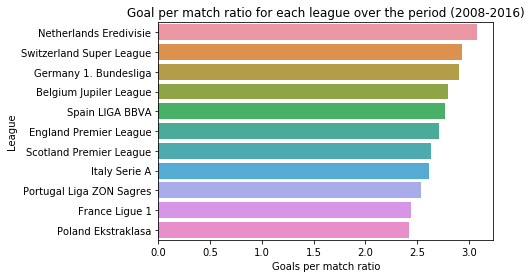

In [92]:
leagues_goals_df.sort_values(by='goals_per_match',ascending=False, inplace=True)
chart = sns.barplot(x='goals_per_match', y='league', data=leagues_goals_df)
chart.set(title='Goal per match ratio for each league over the period (2008-2016)',xlabel='Goals per match ratio', ylabel='League');

In [93]:
leagues_goals_df

id                    league  no_of_matches_played  \
5   13274    Netherlands Eredivisie                  2448   
10  24558  Switzerland Super League                  1422   
3    7809     Germany 1. Bundesliga                  2448   
0       1    Belgium Jupiler League                  1728   
9   21518           Spain LIGA BBVA                  3040   
1    1729    England Premier League                  3040   
8   19694   Scotland Premier League                  1824   
4   10257             Italy Serie A                  3017   
7   17642  Portugal Liga ZON Sagres                  2052   
2    4769            France Ligue 1                  3040   
6   15722        Poland Ekstraklasa                  1920   

    no_of_goals_as_home  no_of_goals_as_away  total_goals  goals_per_match  
5                  4357                 3185         7542         3.080882  
10                 2365                 1801         4166         2.929677  
3                  3982                 3121         7103         2.901552  
0                  2781                 2060         4841         2.801505  
9                  4959                 3453         8412         2.767105  
1                  4715                 3525         8240         2.710526  
8                  2607                 2197         4804         2.633772  
4                  4528                 3367         7895         2.616838  
7                  2890                 2311         5201         2.534600  
2                  4265                 3162         7427         2.443092  
6                  2678                 1978         4656         2.425000

### Now for teams

In [95]:
total_matches_played_per_team_as_home = matches.groupby(['home_team_api_id'])['season'].count()

In [96]:
total_matches_played_per_team_as_away = matches.groupby(['away_team_api_id'])['season'].count()

In [97]:
total_matches_played_per_team = total_matches_played_per_team_as_home + total_matches_played_per_team_as_away

In [98]:
goals_as_home = matches.groupby(['home_team_api_id'])['home_team_goal'].sum()

In [99]:
goals_as_away = matches.groupby(['away_team_api_id'])['away_team_goal'].sum()

In [100]:
total_goals = goals_as_home + goals_as_away

In [101]:
teams_goals_df = pd.DataFrame({'no_of_matches_played':total_matches_played_per_team,'no_of_goals_as_home':goals_as_home,'no_of_goals_as_away':goals_as_away,'total_goals':total_goals})

In [102]:
# Table that shows goals statistics for each team over the data interval time
teams_goals_df

no_of_matches_played  no_of_goals_as_home  no_of_goals_as_away  \
1601                     240                  148                  132   
1773                      90                   74                   52   
1957                     240                  176                  111   
2033                     150                   70                   68   
2182                     240                  215                  157   
...                      ...                  ...                  ...   
158085                    98                   56                   45   
177361                    30                   21                   12   
188163                    34                   15                   19   
208931                    38                   23                   14   
274581                    60                   41                   30   

        total_goals  
1601            280  
1773            126  
1957            287  
2033            138  
2182            372  
...             ...  
158085          101  
177361           33  
188163           34  
208931           37  
274581           71  

[299 rows x 4 columns]

In [103]:
teams_goals_df['goals_per_match'] = teams_goals_df['total_goals'] / teams_goals_df['no_of_matches_played']

In [104]:
teams_goals_df.index.names = ['team_api_id']

In [105]:
teams_goals_df = teams.merge(teams_goals_df, how='inner', left_on='team_api_id', right_on='team_api_id')

In [106]:
teams_goals_df.drop(['team_short_name'], axis=1, inplace=True)

In [107]:
teams_goals_df.head(3)

team_api_id    team_long_name  no_of_matches_played  no_of_goals_as_home  \
0         9987          KRC Genk                   212                  205   
1         9993      Beerschot AC                   152                  112   
2        10000  SV Zulte-Waregem                   212                  176   

   no_of_goals_as_away  total_goals  goals_per_match  
0                  143          348         1.641509  
1                   62          174         1.144737  
2                  130          306         1.443396

<a id='a3b'></a>
#### Answer of question 3b

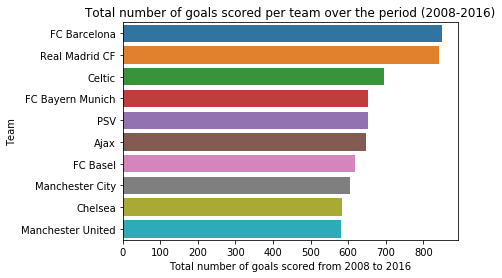

In [108]:
teams_goals_df.sort_values(by='total_goals', ascending=False, inplace=True)
chart = sns.barplot(x='total_goals', y='team_long_name', data=teams_goals_df[:10])
chart.set(title='Total number of goals scored per team over the period (2008-2016)',xlabel='Total number of goals scored from 2008 to 2016', ylabel='Team');

In [109]:
teams_goals_df[:10]

team_api_id     team_long_name  no_of_matches_played  \
258         8634       FC Barcelona                   304   
256         8633     Real Madrid CF                   304   
242         9925             Celtic                   304   
94          9823   FC Bayern Munich                   272   
165         8640                PSV                   272   
161         8593               Ajax                   272   
287         9931           FC Basel                   286   
34          8456    Manchester City                   304   
43          8455            Chelsea                   304   
25         10260  Manchester United                   304   

     no_of_goals_as_home  no_of_goals_as_away  total_goals  goals_per_match  
258                  495                  354          849         2.792763  
256                  505                  338          843         2.773026  
242                  389                  306          695         2.286184  
94                   382                  271          653         2.400735  
165                  370                  282          652         2.397059  
161                  360                  287          647         2.378676  
287                  344                  275          619         2.164336  
34                   365                  241          606         1.993421  
43                   333                  250          583         1.917763  
25                   338                  244          582         1.914474

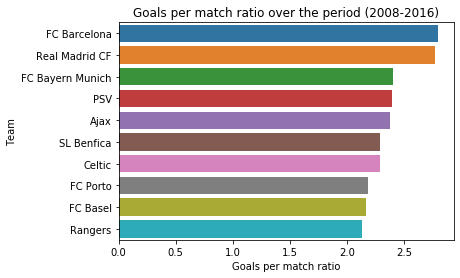

In [111]:
teams_goals_df.sort_values(by='goals_per_match',ascending=False, inplace=True)
chart = sns.barplot(x='goals_per_match', y='team_long_name', data=teams_goals_df[:10])
chart.set(title='Goals per match ratio over the period (2008-2016)',xlabel='Goals per match ratio', ylabel='Team');

In [112]:
teams_goals_df[:10]

team_api_id    team_long_name  no_of_matches_played  no_of_goals_as_home  \
258         8634      FC Barcelona                   304                  495   
256         8633    Real Madrid CF                   304                  505   
94          9823  FC Bayern Munich                   272                  382   
165         8640               PSV                   272                  370   
161         8593              Ajax                   272                  360   
216         9772        SL Benfica                   248                  321   
242         9925            Celtic                   304                  389   
205         9773          FC Porto                   248                  295   
287         9931          FC Basel                   286                  344   
235         8548           Rangers                   152                  177   

     no_of_goals_as_away  total_goals  goals_per_match  
258                  354          849         2.792763  
256                  338          843         2.773026  
94                   271          653         2.400735  
165                  282          652         2.397059  
161                  287          647         2.378676  
216                  247          568         2.290323  
242                  306          695         2.286184  
205                  246          541         2.181452  
287                  275          619         2.164336  
235                  147          324         2.131579


### 3.4 Does different leagues has special team charcteristics?

> **Teams are not related to leagues table except through the matches table, so let's extract the team/league relation from the matches tables**

In [165]:
matches.head()

league_id     season                 date  match_api_id  home_team_api_id  \
0          1  2008/2009  2008-08-17 00:00:00        492473              9987   
1          1  2008/2009  2008-08-16 00:00:00        492474             10000   
2          1  2008/2009  2008-08-16 00:00:00        492475              9984   
3          1  2008/2009  2008-08-17 00:00:00        492476              9991   
4          1  2008/2009  2008-08-16 00:00:00        492477              7947   

   away_team_api_id  home_team_goal  away_team_goal home_result  
0              9993               1               1         tie  
1              9994               0               0         tie  
2              8635               0               3        loss  
3              9998               5               0         win  
4              9985               1               3        loss

In [193]:
team_league_relation = matches[['league_id','home_team_api_id']]

In [194]:
team_league_relation = team_league_relation.drop_duplicates()

In [195]:
team_league_relation

league_id  home_team_api_id
0              1              9987
1              1             10000
2              1              9984
3              1              9991
4              1              7947
...          ...               ...
24739      24558             10190
24918      24558             10191
25100      24558              9777
25105      24558              7730
25815      24558              7896

[299 rows x 2 columns]

In [196]:
team_league_relation = team_league_relation.reset_index(drop=True)

In [185]:
team_attributes

team_api_id       date  buildUpPlaySpeed buildUpPlaySpeedClass  \
0            9930  2009/2010                60              Balanced   
1            9930  2014/2015                52              Balanced   
2            9930  2015/2016                47              Balanced   
3            8485  2009/2010                70                  Fast   
4            8485  2010/2011                47              Balanced   
...           ...        ...               ...                   ...   
1453        10000  2010/2011                52              Balanced   
1454        10000  2011/2012                54              Balanced   
1455        10000  2013/2014                54              Balanced   
1456        10000  2014/2015                54              Balanced   
1457        10000  2015/2016                54              Balanced   

     buildUpPlayDribblingClass  buildUpPlayPassing buildUpPlayPassingClass  \
0                       Little                  50                   Mixed   
1                       Normal                  56                   Mixed   
2                       Normal                  54                   Mixed   
3                       Little                  70                    Long   
4                       Little                  52                   Mixed   
...                        ...                 ...                     ...   
1453                    Little                  52                   Mixed   
1454                    Little                  51                   Mixed   
1455                    Little                  51                   Mixed   
1456                    Normal                  51                   Mixed   
1457                    Normal                  51                   Mixed   

     buildUpPlayPositioningClass  chanceCreationPassing  \
0                      Organised                     60   
1                      Organised                     54   
2                      Organised                     54   
3                      Organised                     70   
4                      Organised                     53   
...                          ...                    ...   
1453                   Organised                     52   
1454                   Organised                     47   
1455                   Organised                     47   
1456                   Organised                     47   
1457                   Organised                     47   

     chanceCreationPassingClass  ...  chanceCreationShooting  \
0                        Normal  ...                      55   
1                        Normal  ...                      64   
2                        Normal  ...                      64   
3                         Risky  ...                      70   
4                        Normal  ...                      52   
...                         ...  ...                     ...   
1453                     Normal  ...                      53   
1454                     Normal  ...                      50   
1455                     Normal  ...                      32   
1456                     Normal  ...                      32   
1457                     Normal  ...                      32   

     chanceCreationShootingClass  chanceCreationPositioningClass  \
0                         Normal                       Organised   
1                         Normal                       Organised   
2                         Normal                       Organised   
3                           Lots                       Organised   
4                         Normal                       Organised   
...                          ...                             ...   
1453                      Normal                       Organised   
1454                      Normal                       Organised   
1455                      Little                       Organised   
1456                      Little              

> **Now, let's merge this relation to the team attributes table**

In [197]:
team_atts_vs_league_df = team_attributes.merge(team_league_relation, how='inner', left_on='team_api_id', right_on='home_team_api_id')

In [198]:
team_atts_vs_league_df

team_api_id       date  buildUpPlaySpeed buildUpPlaySpeedClass  \
0            9930  2009/2010                60              Balanced   
1            9930  2014/2015                52              Balanced   
2            9930  2015/2016                47              Balanced   
3            8485  2009/2010                70                  Fast   
4            8485  2010/2011                47              Balanced   
...           ...        ...               ...                   ...   
1453        10000  2010/2011                52              Balanced   
1454        10000  2011/2012                54              Balanced   
1455        10000  2013/2014                54              Balanced   
1456        10000  2014/2015                54              Balanced   
1457        10000  2015/2016                54              Balanced   

     buildUpPlayDribblingClass  buildUpPlayPassing buildUpPlayPassingClass  \
0                       Little                  50                   Mixed   
1                       Normal                  56                   Mixed   
2                       Normal                  54                   Mixed   
3                       Little                  70                    Long   
4                       Little                  52                   Mixed   
...                        ...                 ...                     ...   
1453                    Little                  52                   Mixed   
1454                    Little                  51                   Mixed   
1455                    Little                  51                   Mixed   
1456                    Normal                  51                   Mixed   
1457                    Normal                  51                   Mixed   

     buildUpPlayPositioningClass  chanceCreationPassing  \
0                      Organised                     60   
1                      Organised                     54   
2                      Organised                     54   
3                      Organised                     70   
4                      Organised                     53   
...                          ...                    ...   
1453                   Organised                     52   
1454                   Organised                     47   
1455                   Organised                     47   
1456                   Organised                     47   
1457                   Organised                     47   

     chanceCreationPassingClass  ...  chanceCreationPositioningClass  \
0                        Normal  ...                       Organised   
1                        Normal  ...                       Organised   
2                        Normal  ...                       Organised   
3                         Risky  ...                       Organised   
4                        Normal  ...                       Organised   
...                         ...  ...                             ...   
1453                     Normal  ...                       Organised   
1454                     Normal  ...                       Organised   
1455                     Normal  ...                       Organised   
1456                     Normal  ...                       Organised   
1457                     Normal  ...                       Organised   

     defencePressure  defencePressureClass defenceAggression  \
0                 50                Medium                55   
1                 47                Medium                44   
2                 47                Medium                44   
3                 60                Medium                70   
4                 47                Medium                47   
...              ...                   ...               ...   
1453              46                Medium                48   
1454              44                Medium                55   
1455              44                Medium            

In [199]:
team_atts_vs_league_df.drop(['home_team_api_id'], axis=1, inplace=True)

In [201]:
# Let's add the league name for visualization charts
team_atts_vs_league_df = team_atts_vs_league_df.merge(leagues, how='inner',left_on='league_id', right_on='id')

In [202]:
team_atts_vs_league_df.drop(['team_api_id','date','league_id','id','country'],axis=1, inplace=True)

In [203]:
team_atts_vs_league_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1458 entries, 0 to 1457
Data columns (total 21 columns):
buildUpPlaySpeed                  1458 non-null int64
buildUpPlaySpeedClass             1458 non-null object
buildUpPlayDribblingClass         1458 non-null object
buildUpPlayPassing                1458 non-null int64
buildUpPlayPassingClass           1458 non-null object
buildUpPlayPositioningClass       1458 non-null object
chanceCreationPassing             1458 non-null int64
chanceCreationPassingClass        1458 non-null object
chanceCreationCrossing            1458 non-null int64
chanceCreationCrossingClass       1458 non-null object
chanceCreationShooting            1458 non-null int64
chanceCreationShootingClass       1458 non-null object
chanceCreationPositioningClass    1458 non-null object
defencePressure                   1458 non-null int64
defencePressureClass              1458 non-null object
defenceAggression                 1458 non-null int64
defenceAggressionCla

<a id='a4'></a>
#### Answer of question 4

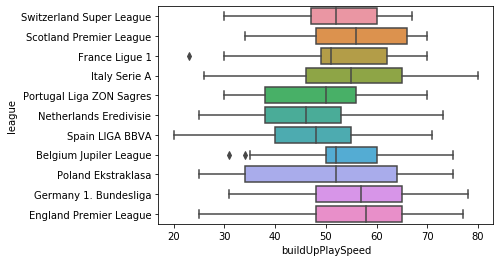

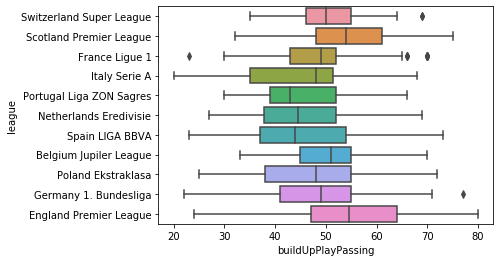

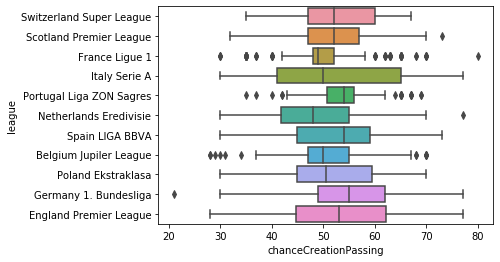

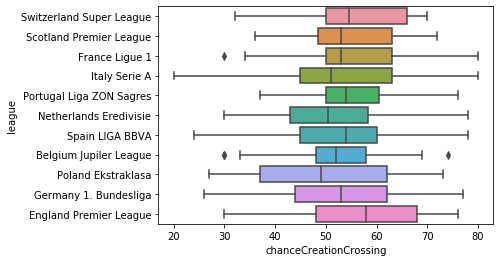

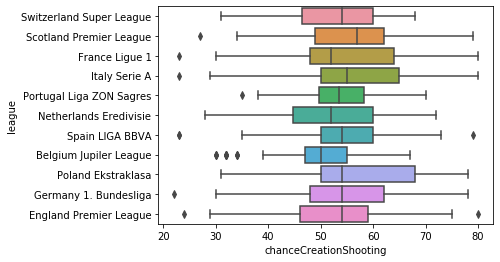

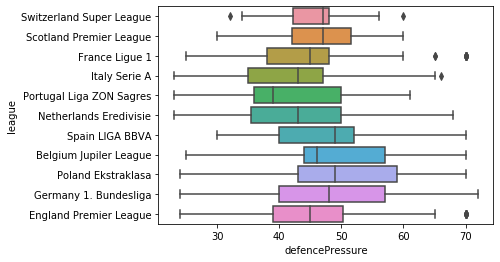

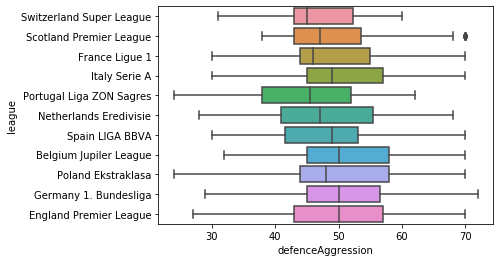

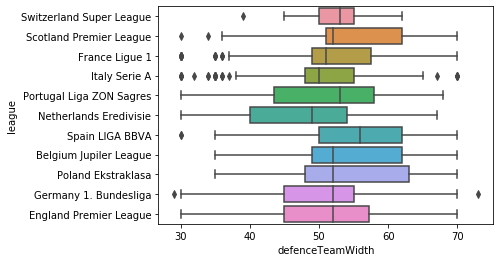

In [205]:
for i, col in enumerate(team_atts_vs_league_df.columns):
    if ( type(team_atts_vs_league_df[col][0]) == type(team_atts_vs_league_df['buildUpPlaySpeed'][0]) ):
        plt.figure(i);
        chart = sns.boxplot(x=col, y="league", data=team_atts_vs_league_df);

----------------------------------------

### 3.5 Who are the best players in Europe over these years (2008-2016)

In [206]:
players.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11060 entries, 0 to 11059
Data columns (total 5 columns):
player_api_id    11060 non-null int64
player_name      11060 non-null object
birthday         11060 non-null object
height           11060 non-null float64
weight           11060 non-null int64
dtypes: float64(1), int64(2), object(2)
memory usage: 432.2+ KB


In [207]:
players_attributes.columns

Index(['player_api_id', 'date', 'overall_rating', 'potential',
       'preferred_foot', 'attacking_work_rate', 'defensive_work_rate',
       'crossing', 'finishing', 'heading_accuracy', 'short_passing', 'volleys',
       'dribbling', 'curve', 'free_kick_accuracy', 'long_passing',
       'ball_control', 'acceleration', 'sprint_speed', 'agility', 'reactions',
       'balance', 'shot_power', 'jumping', 'stamina', 'strength', 'long_shots',
       'aggression', 'interceptions', 'positioning', 'vision', 'penalties',
       'marking', 'standing_tackle', 'sliding_tackle', 'gk_diving',
       'gk_handling', 'gk_kicking', 'gk_positioning', 'gk_reflexes'],
      dtype='object')

In [208]:
players_analysis_df = players_attributes.merge(players, how='left', left_on='player_api_id', right_on='player_api_id')

In [211]:
players_analysis_df.head(3)

player_api_id                 date  overall_rating  potential  \
0         505942  2016-02-18 00:00:00            67.0       71.0   
1         505942  2015-11-19 00:00:00            67.0       71.0   
2         505942  2015-09-21 00:00:00            62.0       66.0   

  preferred_foot attacking_work_rate defensive_work_rate  crossing  finishing  \
0          right              medium              medium      49.0       44.0   
1          right              medium              medium      49.0       44.0   
2          right              medium              medium      49.0       44.0   

   heading_accuracy  ...  sliding_tackle  gk_diving  gk_handling  gk_kicking  \
0              71.0  ...            69.0        6.0         11.0        10.0   
1              71.0  ...            69.0        6.0         11.0        10.0   
2              71.0  ...            69.0        6.0         11.0        10.0   

   gk_positioning  gk_reflexes         player_name             birthday  \
0             8.0          8.0  Aaron Appindangoye  1992-02-29 00:00:00   
1             8.0          8.0  Aaron Appindangoye  1992-02-29 00:00:00   
2             8.0          8.0  Aaron Appindangoye  1992-02-29 00:00:00   

   height  weight  
0  182.88     187  
1  182.88     187  
2  182.88     187  

[3 rows x 44 columns]

In [212]:
players_names = players_analysis_df.groupby(['player_api_id'])['player_name'].first()

In [213]:
players_names

player_api_id
2625      Patryk Rachwal,18
2752            Diego Mainz
2768            Jose Dorado
2770       Ignacio Gonzalez
2790            Alberto Rey
                ...        
744907          Greg Taylor
746419     Francisco Afonso
748432       Fynn Arkenberg
750435       Rees Greenwood
750584    Alexandre Azevedo
Name: player_name, Length: 11060, dtype: object

<a id='a5'></a>
#### Answer of question 5

/home/omar/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  after removing the cwd from sys.path.


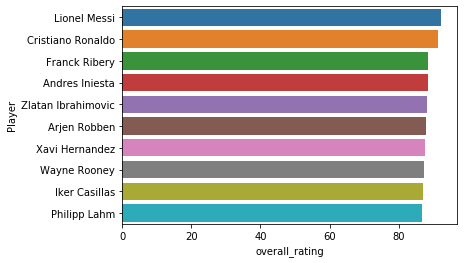

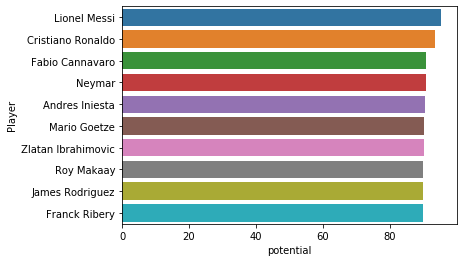

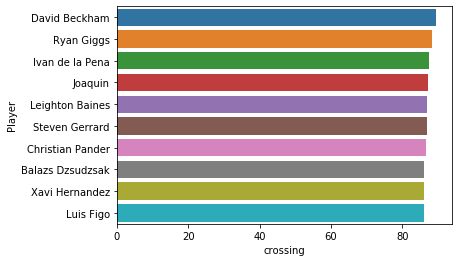

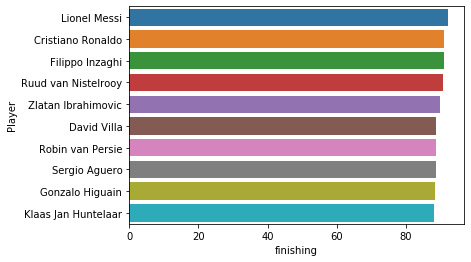

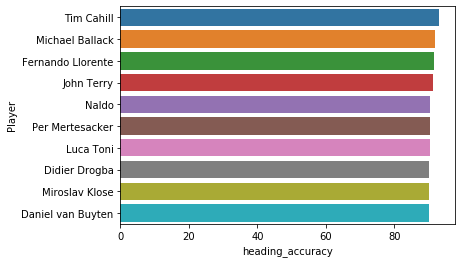

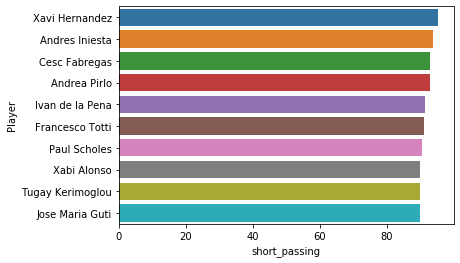

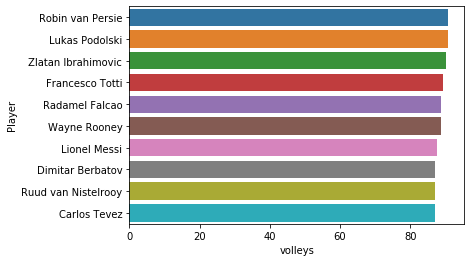

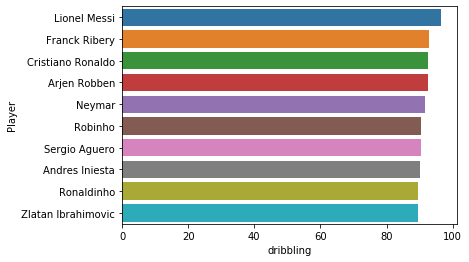

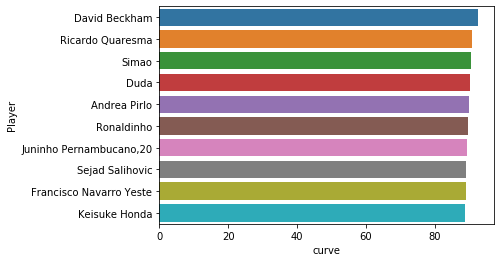

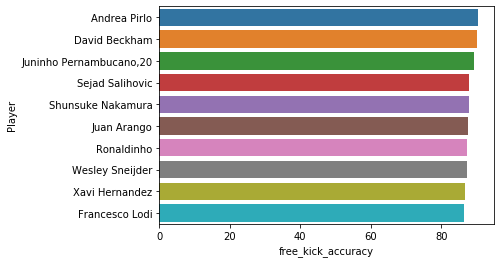

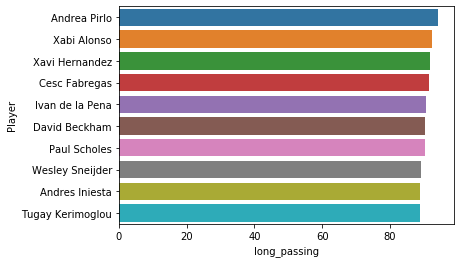

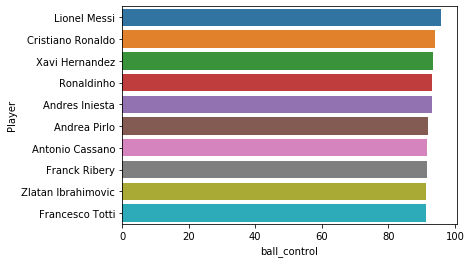

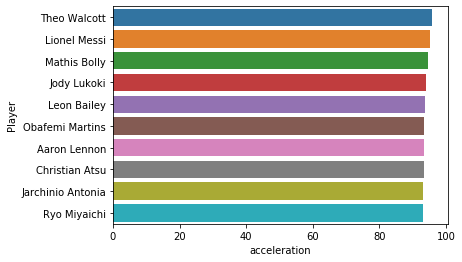

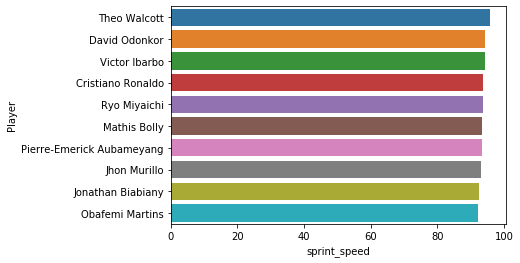

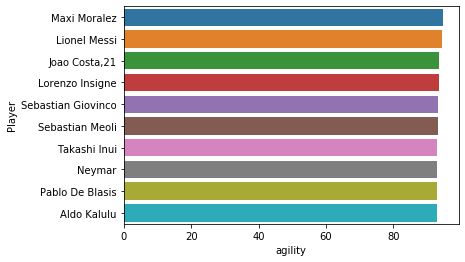

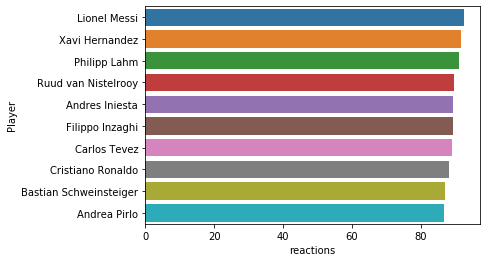

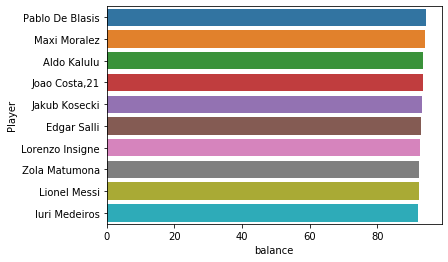

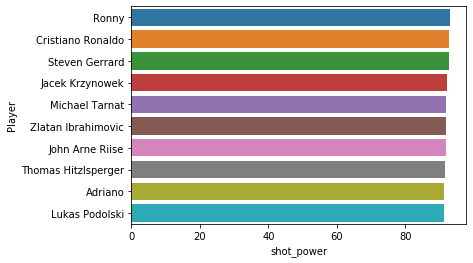

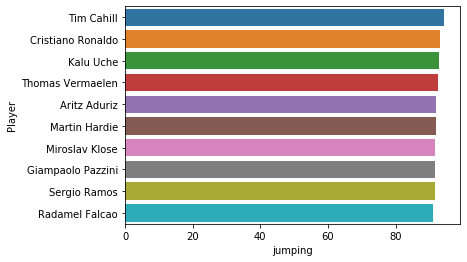

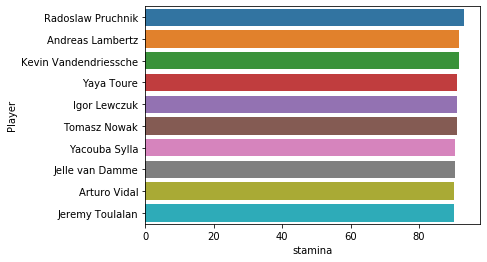

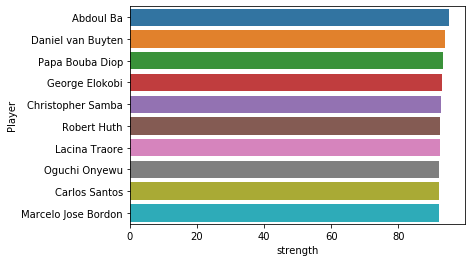

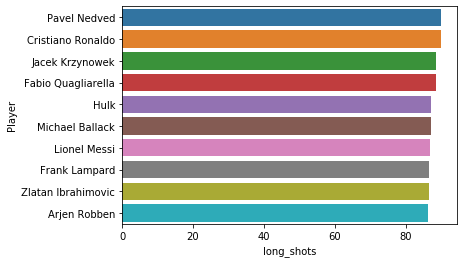

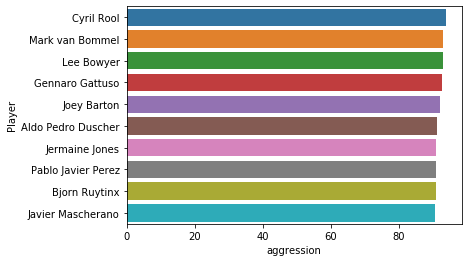

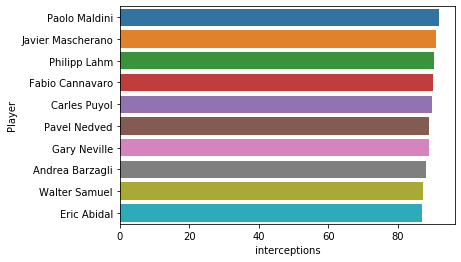

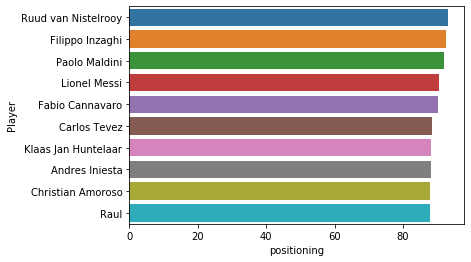

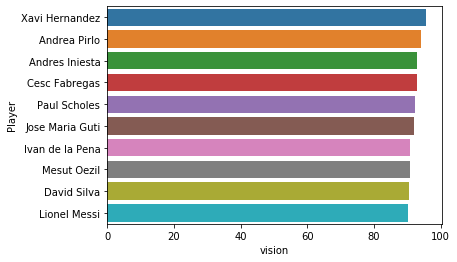

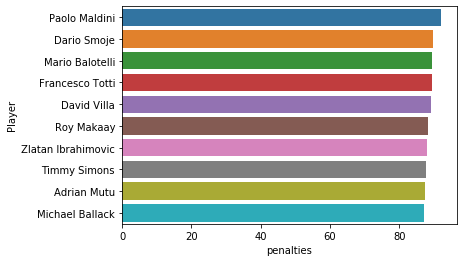

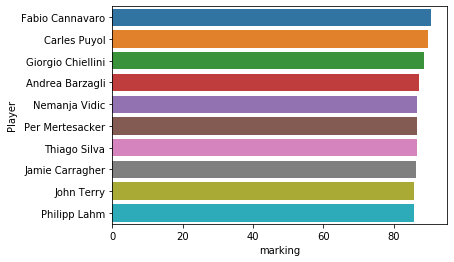

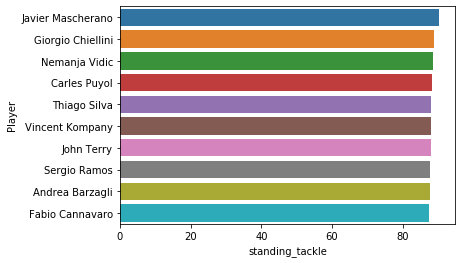

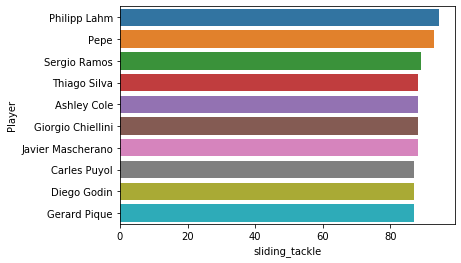

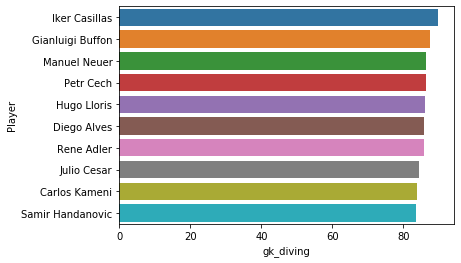

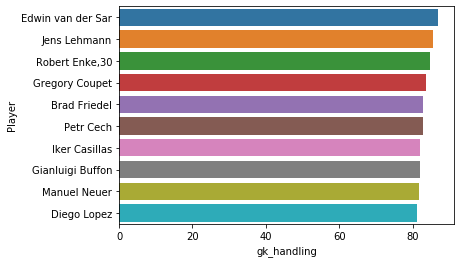

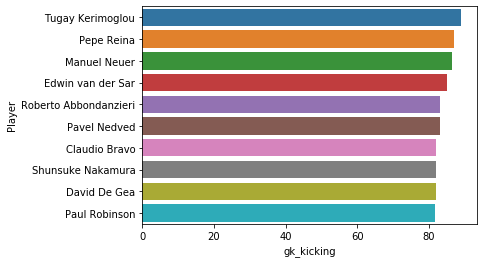

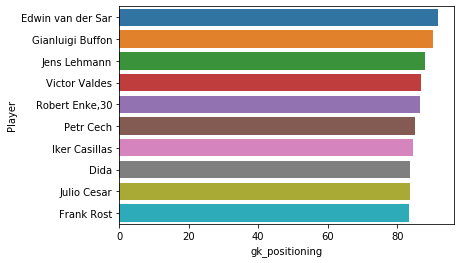

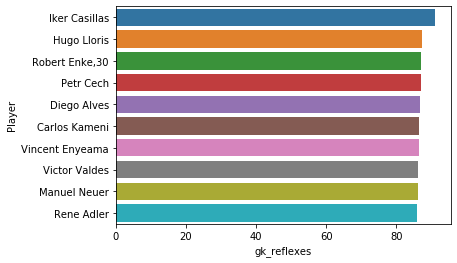

In [217]:
for i, col in enumerate(players_analysis_df.columns):
    if (i<41):
        if ( type(players_analysis_df[col][0]) == type(players_analysis_df['overall_rating'][0]) ):
            plt.figure(i);
            mean_of_attribute = players_analysis_df.groupby(['player_api_id'])[col].mean()
            player_vs_att_df = pd.DataFrame({'name':players_names, col:mean_of_attribute})
            player_vs_att_df = player_vs_att_df.sort_values(by=col,ascending=False)
            chart = sns.barplot(x=col, y='name', data=player_vs_att_df[:10]);
            chart.set(ylabel='Player')

------------------------------------------

### 3.6 Relationship between players height and weight vs player attributes?

In [219]:
players_analysis_df.head(2)

player_api_id                 date  overall_rating  potential  \
0         505942  2016-02-18 00:00:00            67.0       71.0   
1         505942  2015-11-19 00:00:00            67.0       71.0   

  preferred_foot attacking_work_rate defensive_work_rate  crossing  finishing  \
0          right              medium              medium      49.0       44.0   
1          right              medium              medium      49.0       44.0   

   heading_accuracy  ...  sliding_tackle  gk_diving  gk_handling  gk_kicking  \
0              71.0  ...            69.0        6.0         11.0        10.0   
1              71.0  ...            69.0        6.0         11.0        10.0   

   gk_positioning  gk_reflexes         player_name             birthday  \
0             8.0          8.0  Aaron Appindangoye  1992-02-29 00:00:00   
1             8.0          8.0  Aaron Appindangoye  1992-02-29 00:00:00   

   height  weight  
0  182.88     187  
1  182.88     187  

[2 rows x 44 columns]

<a id='a6'></a>
#### Answer of question 6

/home/omar/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  after removing the cwd from sys.path.


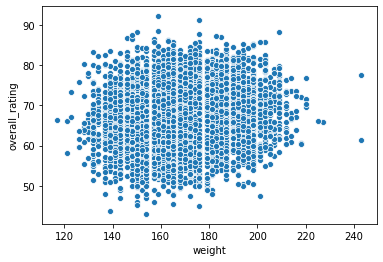

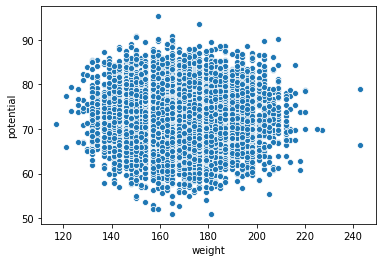

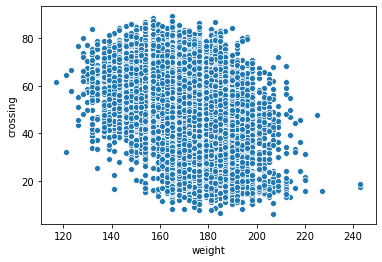

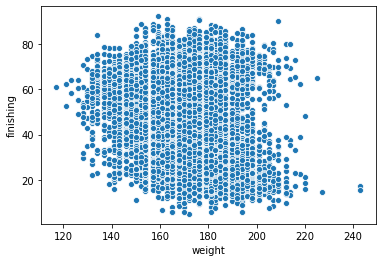

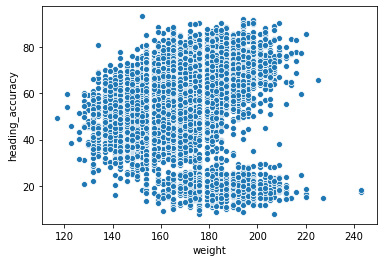

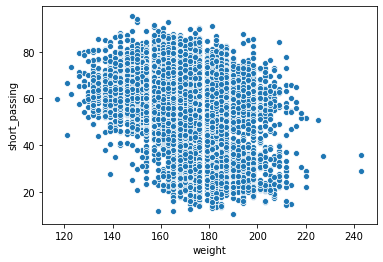

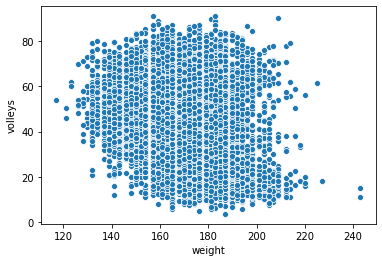

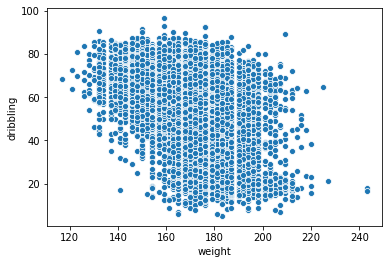

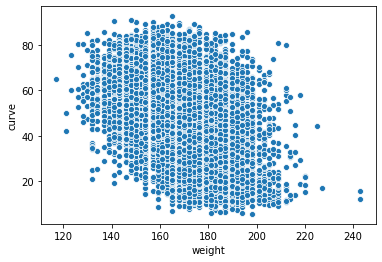

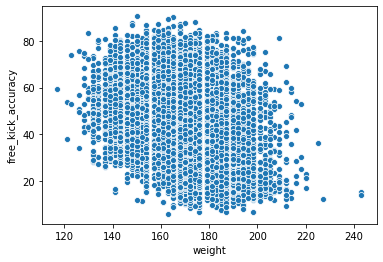

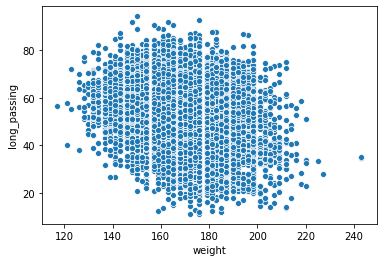

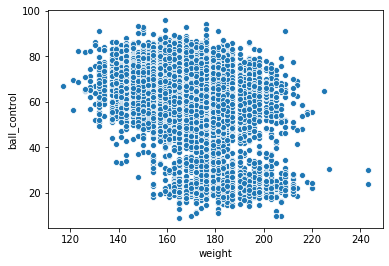

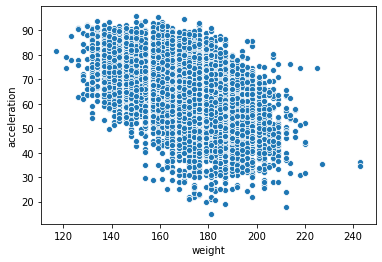

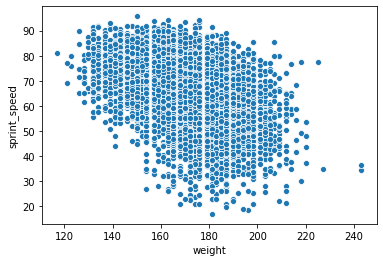

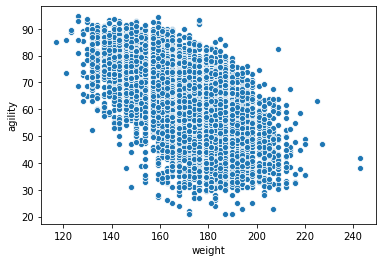

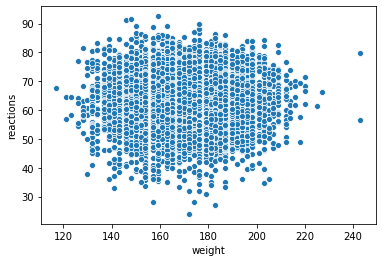

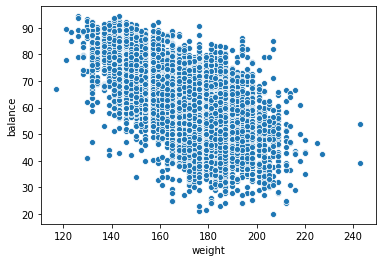

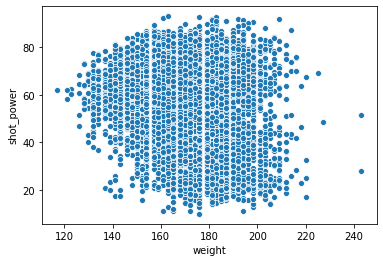

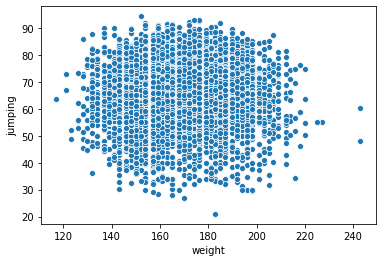

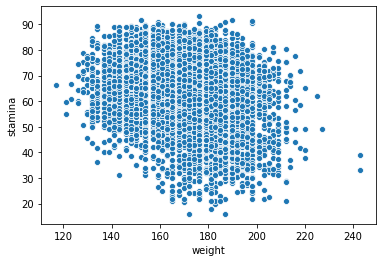

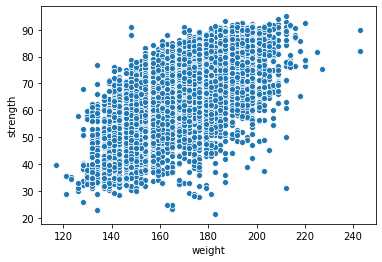

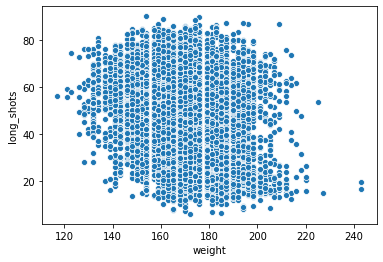

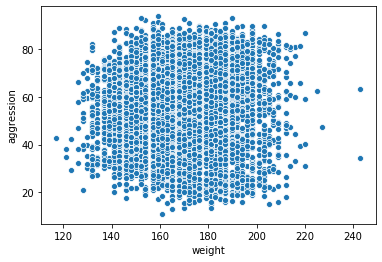

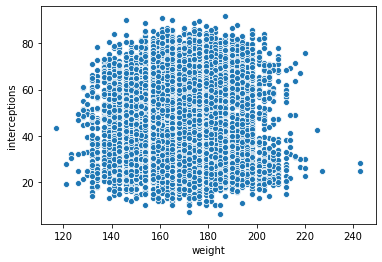

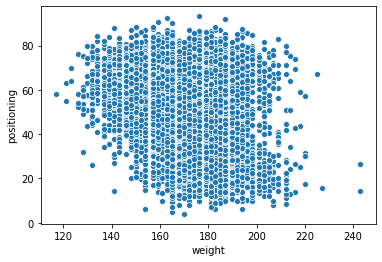

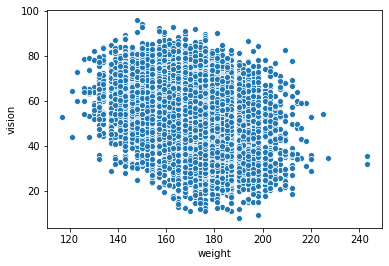

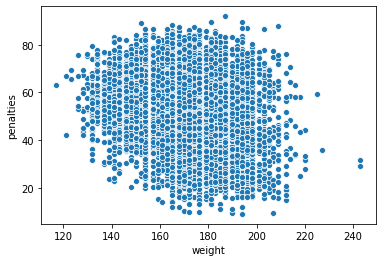

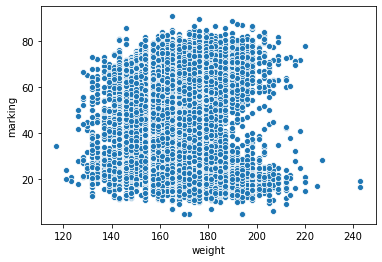

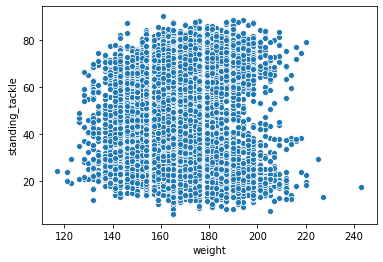

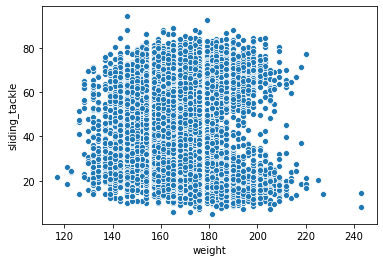

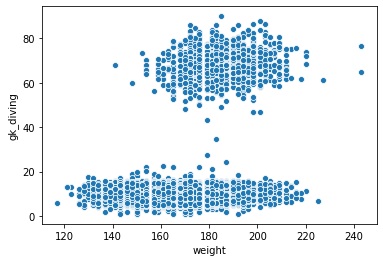

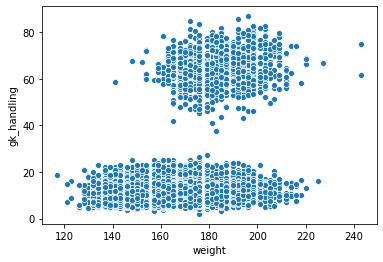

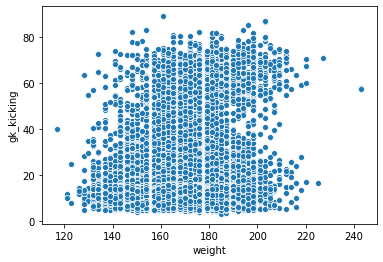

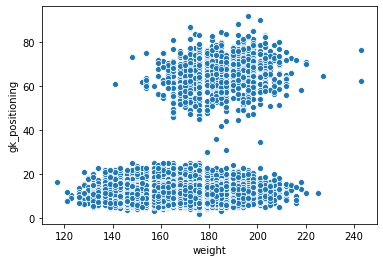

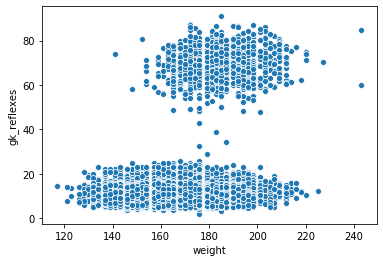

In [221]:
for i, col in enumerate(players_analysis_df.columns):
    if (i<41):
        if ( type(players_analysis_df[col][0]) == type(players_analysis_df['overall_rating'][0]) ):
            plt.figure(i);
            df = players_analysis_df.groupby(['player_api_id']).mean()
            sns.scatterplot(x='weight',y=col, data=df);

/home/omar/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  after removing the cwd from sys.path.


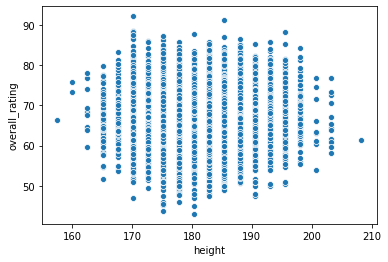

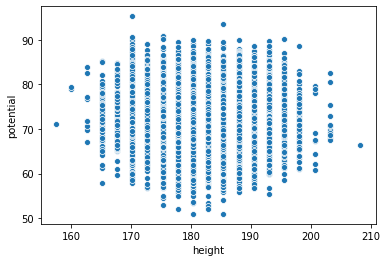

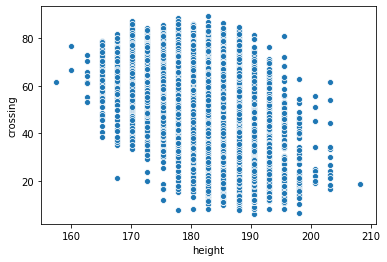

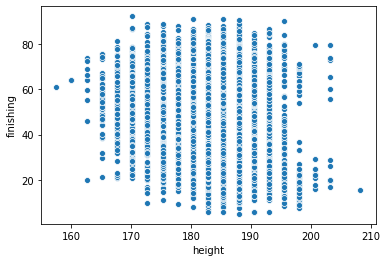

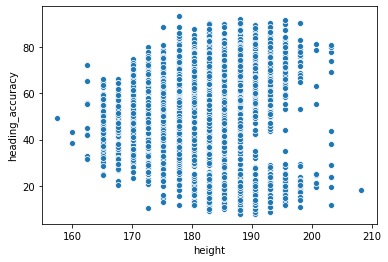

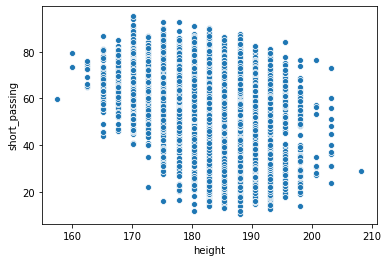

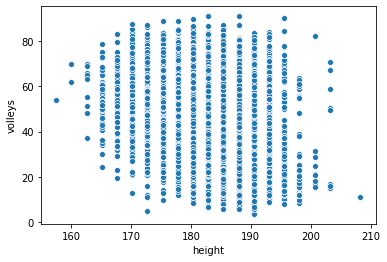

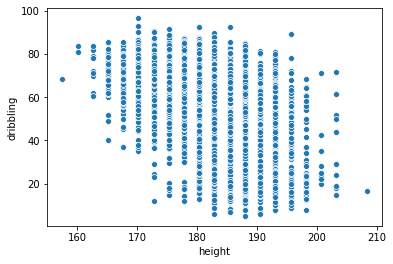

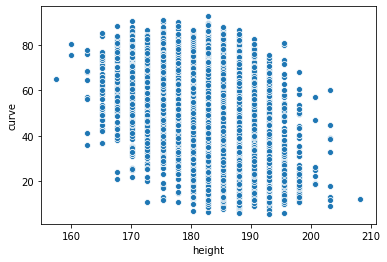

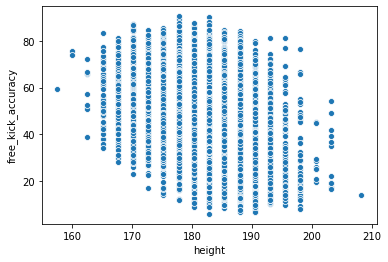

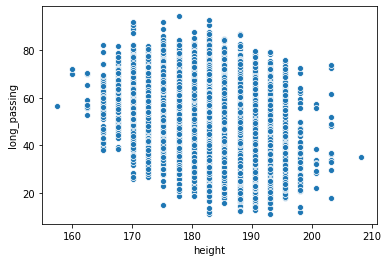

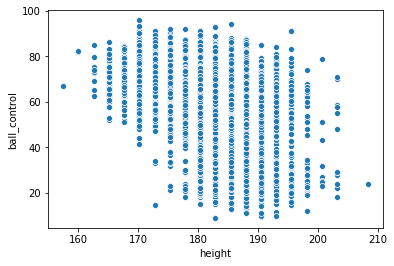

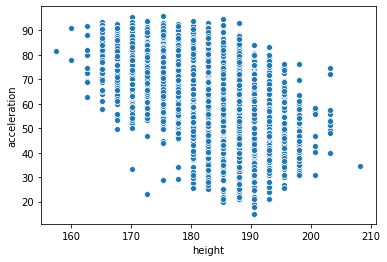

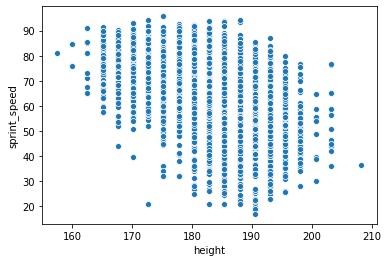

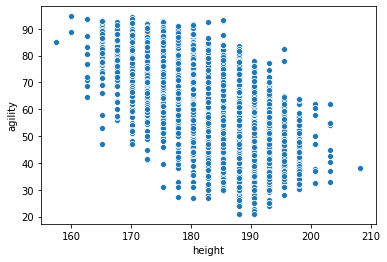

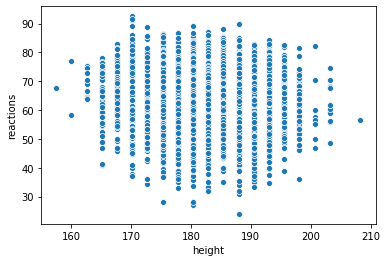

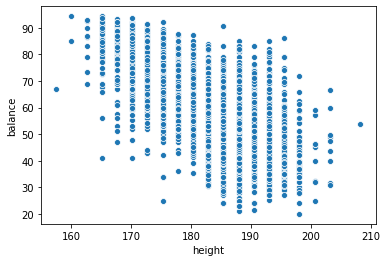

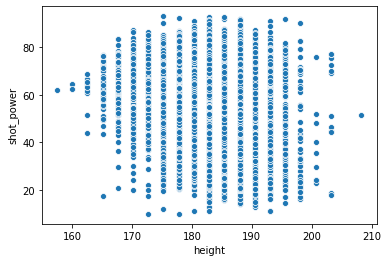

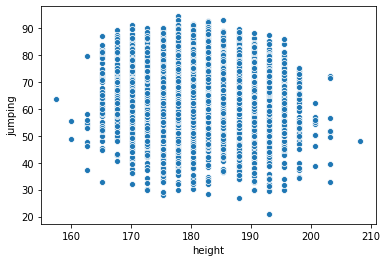

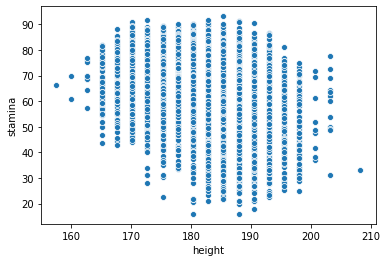

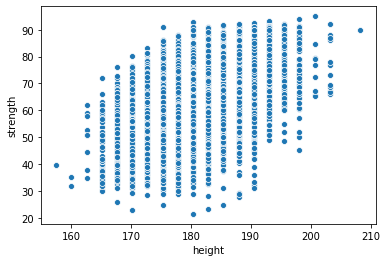

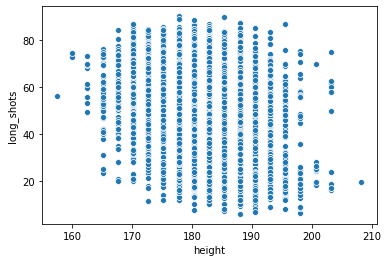

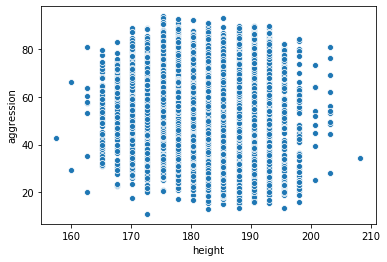

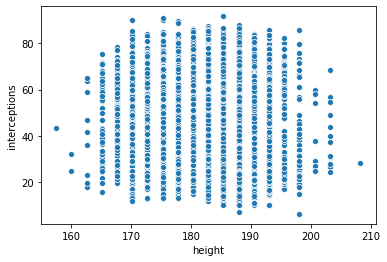

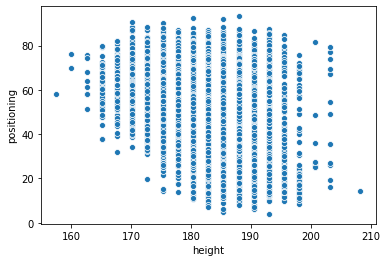

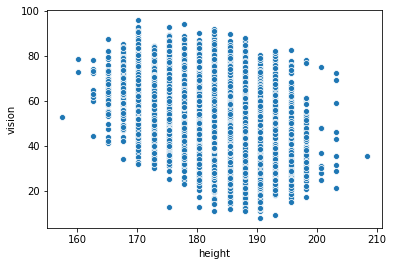

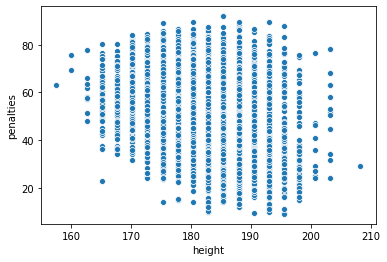

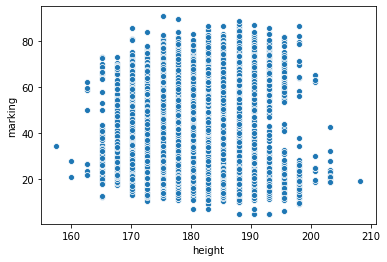

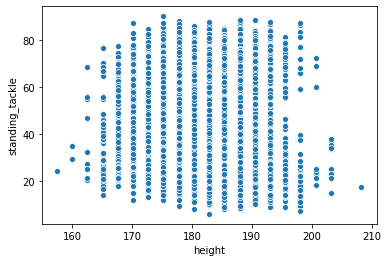

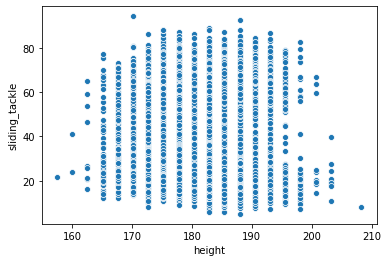

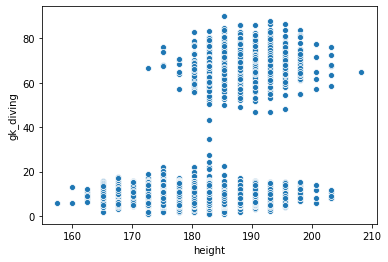

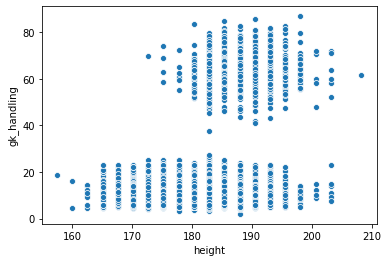

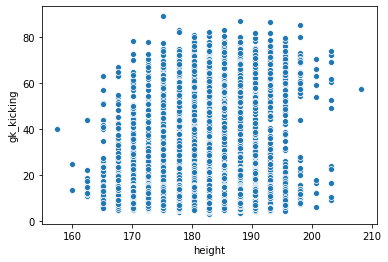

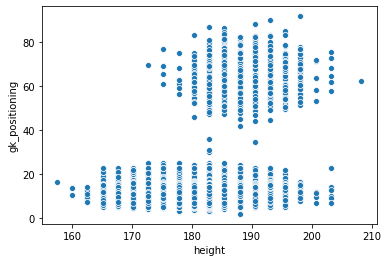

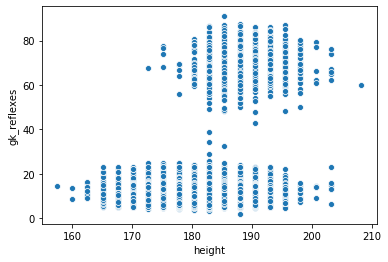

In [222]:
for i, col in enumerate(players_analysis_df.columns):
    if (i<41):
        if ( type(players_analysis_df[col][0]) == type(players_analysis_df['overall_rating'][0]) ):
            plt.figure(i);
            df = players_analysis_df.groupby(['player_api_id']).mean()
            sns.scatterplot(x='height',y=col, data=df);

---------------------------------------

<a id='conclusions'></a>
## Conclusions

<font size="3">It is important to mention that the data of this dataset is recorded from different sources as soccer data websites and also from video games data as fifa video game, so some data may have been approximted to some extent before being collected by the dataset author</font>

